# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import LabelPropagation
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE, SequentialFeatureSelector
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
import warnings
warnings.filterwarnings('ignore')


In [2]:
url = 'https://media.githubusercontent.com/media/shahriariit/opendataset/master/PhiUSIIL_phishing.csv'
data = pd.read_csv(url)
data.head()

,URLLength,DomainLength,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,31,24,231,100.0,1.000000,0.522907,0.061933,3,1,0,...,0,0,1,34,20,28,119,0,124,1
1,23,16,254,100.0,0.666667,0.032650,0.050207,2,1,0,...,0,0,1,50,9,8,39,0,217,1
2,29,22,647,100.0,0.866667,0.028555,0.064129,2,2,0,...,0,0,1,10,2,7,42,2,5,1
3,26,19,231,100.0,1.000000,0.522907,0.057606,3,1,0,...,1,1,1,3,27,15,22,1,31,1
4,33,26,503,100.0,1.000000,0.079963,0.059441,3,1,0,...,1,0,1,244,15,34,72,1,85,1


In [ ]:
data.shape

(235795, 49)

In [3]:
def datapartition(data):
    M = data.drop('label', axis=1)
    n = data['label']
    x_train, x_test, y_train, y_test = train_test_split(M, n, test_size=0.2, random_state=42)
    return x_train, x_test, y_train, y_test

In [4]:
def data_split_simulation(df, num_unlabeled):
    M = df.drop('label', axis=1)
    n = df['label']
    unlabeled_indices= np.random.choice(len(M), num_unlabeled, replace=False)
    n.iloc[unlabeled_indices] = -1
    X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(M, n, test_size=num_unlabeled, random_state=42, stratify=n)
    return X_labeled, X_unlabeled, y_labeled, y_unlabeled

In [5]:
def correlation_analysis(threshold):
    # Find pairs of highly correlated features
    high_corr_var = np.where((correlation_matrix >= threshold) | (correlation_matrix <= -threshold))
    high_corr_pairs = [(correlation_matrix.columns[x], correlation_matrix.columns[y])
                   for x, y in zip(*high_corr_var) if x != y and x < y]

     # Display the highly correlated pairs
    for pair in high_corr_pairs:
        print(pair)

In [6]:
def top_features_from_kbest(data):
  FIT_FEATURES = SelectKBest(score_func=f_classif)
  M = data.drop('label', axis=1)
  n = data['label']
  FIT_FEATURES.fit(M,n)
  score_col=pd.DataFrame(FIT_FEATURES.scores_, columns=['score_value'])
  name_col=pd.DataFrame(M.columns)
  top_features=pd.concat([name_col, score_col], axis=1)
  top_features.columns=['feature_name', 'score_value']
  top_features_sorted = top_features.sort_values('score_value', ascending=False)
  print(top_features_sorted)

In [7]:
def top_feature_from_rfe(data):
    M = data.drop('label', axis=1)
    n = data['label']
    rf = RandomForestClassifier(random_state=42) # Aligned with the function definition
    num_features = 15
    rfe = RFE(estimator=rf, n_features_to_select=num_features)
    rfe.fit(M, n)

    selected_features = M.columns[rfe.support_]
    top_feature= M[selected_features]
    print(top_feature)
    return selected_features, top_feature

In [8]:
def top_features_from_mi(data):

    FIT_FEATURES = SelectKBest(score_func=mutual_info_classif, k='all')
    X = data.drop('label', axis=1)
    y = data['label']

    FIT_FEATURES.fit(X, y)

    score_col = pd.DataFrame(FIT_FEATURES.scores_, columns=['score_value'])
    name_col = pd.DataFrame(X.columns, columns=['feature_name'])

    top_features = pd.concat([name_col, score_col], axis=1)
    top_features_sorted = top_features.sort_values('score_value', ascending=False)

    return top_features_sorted

In [9]:
def top_features_from_sfs(data):
    log_reg = LogisticRegression(max_iter=1000)  # Default model
    M = data.drop('label', axis=1)
    n = data['label']

    SFS = SequentialFeatureSelector(
        log_reg,
        n_features_to_select=15,  # Select 15 features
        direction="forward",  # Forward selection
        cv=5  # 5-fold cross-validation
    )
    SFS.fit(M, n)
    selected_features = np.array(M.columns)[SFS.get_support()]
    top_feature= M[selected_features]
    print(selected_features)
    return selected_features, top_feature

In [10]:
def top_features_from_importance(data):
    MODEL = RandomForestClassifier()
    M = data.drop('label', axis=1)
    n = data['label']

    MODEL.fit(M, n)
    feature_importances = MODEL.feature_importances_

    feature_scores = pd.DataFrame({'feature_name': M.columns, 'importance_score': feature_importances})
    top_features = feature_scores.sort_values(by='importance_score', ascending=False).head(15)

    print(top_features['feature_name'].values)
    return data[top_features['feature_name'].tolist() + ['label']]


In [11]:
def top_features_from_lr_importance(data):
    MODEL = LogisticRegression(max_iter=1000)  # Increase iterations for convergence
    M = data.drop('label', axis=1)
    n = data['label']

    MODEL.fit(M, n)
    feature_importances = np.abs(MODEL.coef_)[0]  # Get absolute coefficient values

    feature_scores = pd.DataFrame({'feature_name': M.columns, 'importance_score': feature_importances})
    top_features = feature_scores.sort_values(by='importance_score', ascending=False).head(15)

    print(top_features['feature_name'].values)
    return data[top_features['feature_name'].tolist() + ['label']]

In [12]:
def top_features_from_sfs(data):
    MODEL = GaussianNB()
    M = data.drop('label', axis=1)
    n = data['label']

    SFS = SequentialFeatureSelector(
        MODEL,
        n_features_to_select=15,
        direction="forward",
        cv=3,
        n_jobs=-1  # Parallel processing
    )
    SFS.fit(M, n) #Fixed the indentation error by removing the extra space
    selected_features = np.array(M.columns)[SFS.get_support()]

    selected_features_list = selected_features.tolist() + ['label']
    print(selected_features_list)
    return data[selected_features_list]

In [15]:

def top_features_from_pca(data):

    M = data.drop('label', axis=1)  # Feature matrix
    n = data['label']  # Target variable

    # Standardize the features before PCA
    scaler = StandardScaler()
    M_scaled = scaler.fit_transform(M)

    # Apply PCA with automatic selection based on variance retention (85%)
    pca = PCA(n_components=0.85)
    M_pca = pca.fit_transform(M_scaled)

    # Get the number of selected components
    n_selected_components = pca.n_components_

    # Convert PCA components into a DataFrame
    pca_columns = [f'PC{i+1}' for i in range(n_selected_components)]
    pca_df = pd.DataFrame(M_pca, columns=pca_columns)

    # Add the target variable back
    pca_df['label'] = n.reset_index(drop=True)

    print(f"Selected {n_selected_components} components to retain 95% variance.")
    print(f"Explained Variance Ratio of Selected Components: {pca.explained_variance_ratio_.sum()}")

    return pca_df


In [16]:
def remove_outliers_iqr(df, k=1.5):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    return df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

In [17]:
def z_score_tranformation(df_train, df_test):
  scaler = StandardScaler()
  df_train_scaled = scaler.fit_transform(df_train)
  df_test_scaled = scaler.transform(df_test)
  return df_train_scaled, df_test_scaled

In [18]:
def min_max_tranformation(df_train, df_test):
  scaler = MinMaxScaler()
  df_train_scaled = scaler.fit_transform(df_train)
  df_test_scaled = scaler.transform(df_test)
  return df_train_scaled, df_test_scaled

In [19]:
def log_tranformation(df_train, df_test):
  df_train_log = np.log1p(df_train)
  df_test_log = np.log1p(df_test)
  return df_train_log, df_test_log

In [20]:
def classification_metrics(X_labeled, X_unlabeled, y_labeled, y_unlabeled):
    models = {
        "label-propagation": LabelPropagation(kernel='knn', n_neighbors=10),
       "KNeighbors": KNeighborsClassifier(),
       "Random Forest": RandomForestClassifier(random_state=42),
       "Gradient Boosting": GradientBoostingClassifier(random_state=42),
       "Logistic Regression": LogisticRegression(),
       "Decision Tree": DecisionTreeClassifier(random_state=42),
       "Naive Bayes": GaussianNB(),
       "AdaBoost": AdaBoostClassifier(random_state=42),
       "Linear SVC": LinearSVC(random_state=42, max_iter=5000),
    }

    for name, model in models.items():
       print(f"--- {name} ---")
       model.fit(X_labeled, y_labeled)
       y_pred = model.predict(X_unlabeled)

       accuracy = accuracy_score(y_unlabeled, y_pred)
       precision = precision_score(y_unlabeled, y_pred, average='weighted')
       recall = recall_score(y_unlabeled, y_pred, average='weighted')
       f_measure = f1_score(y_unlabeled, y_pred, average='weighted')

       print(f"Accuracy: {accuracy:.4f}")
       print(f"Precision: {precision:.4f}")
       print(f"Recall: {recall:.4f}")
       print(f"F-Measure: {f_measure:.4f}\n")

In [21]:
data_fs_1= data.copy()
data_fs_2= data.copy()
data_fs_3= data.copy()
data_fs_4= data.copy()
data_fs_5= data.copy()
data_fs_6= data.copy()
data_fs_7= data.copy()
data_pcaV_8= data.copy()

# Feature Selection Methods

## Correlation based Feature Selection

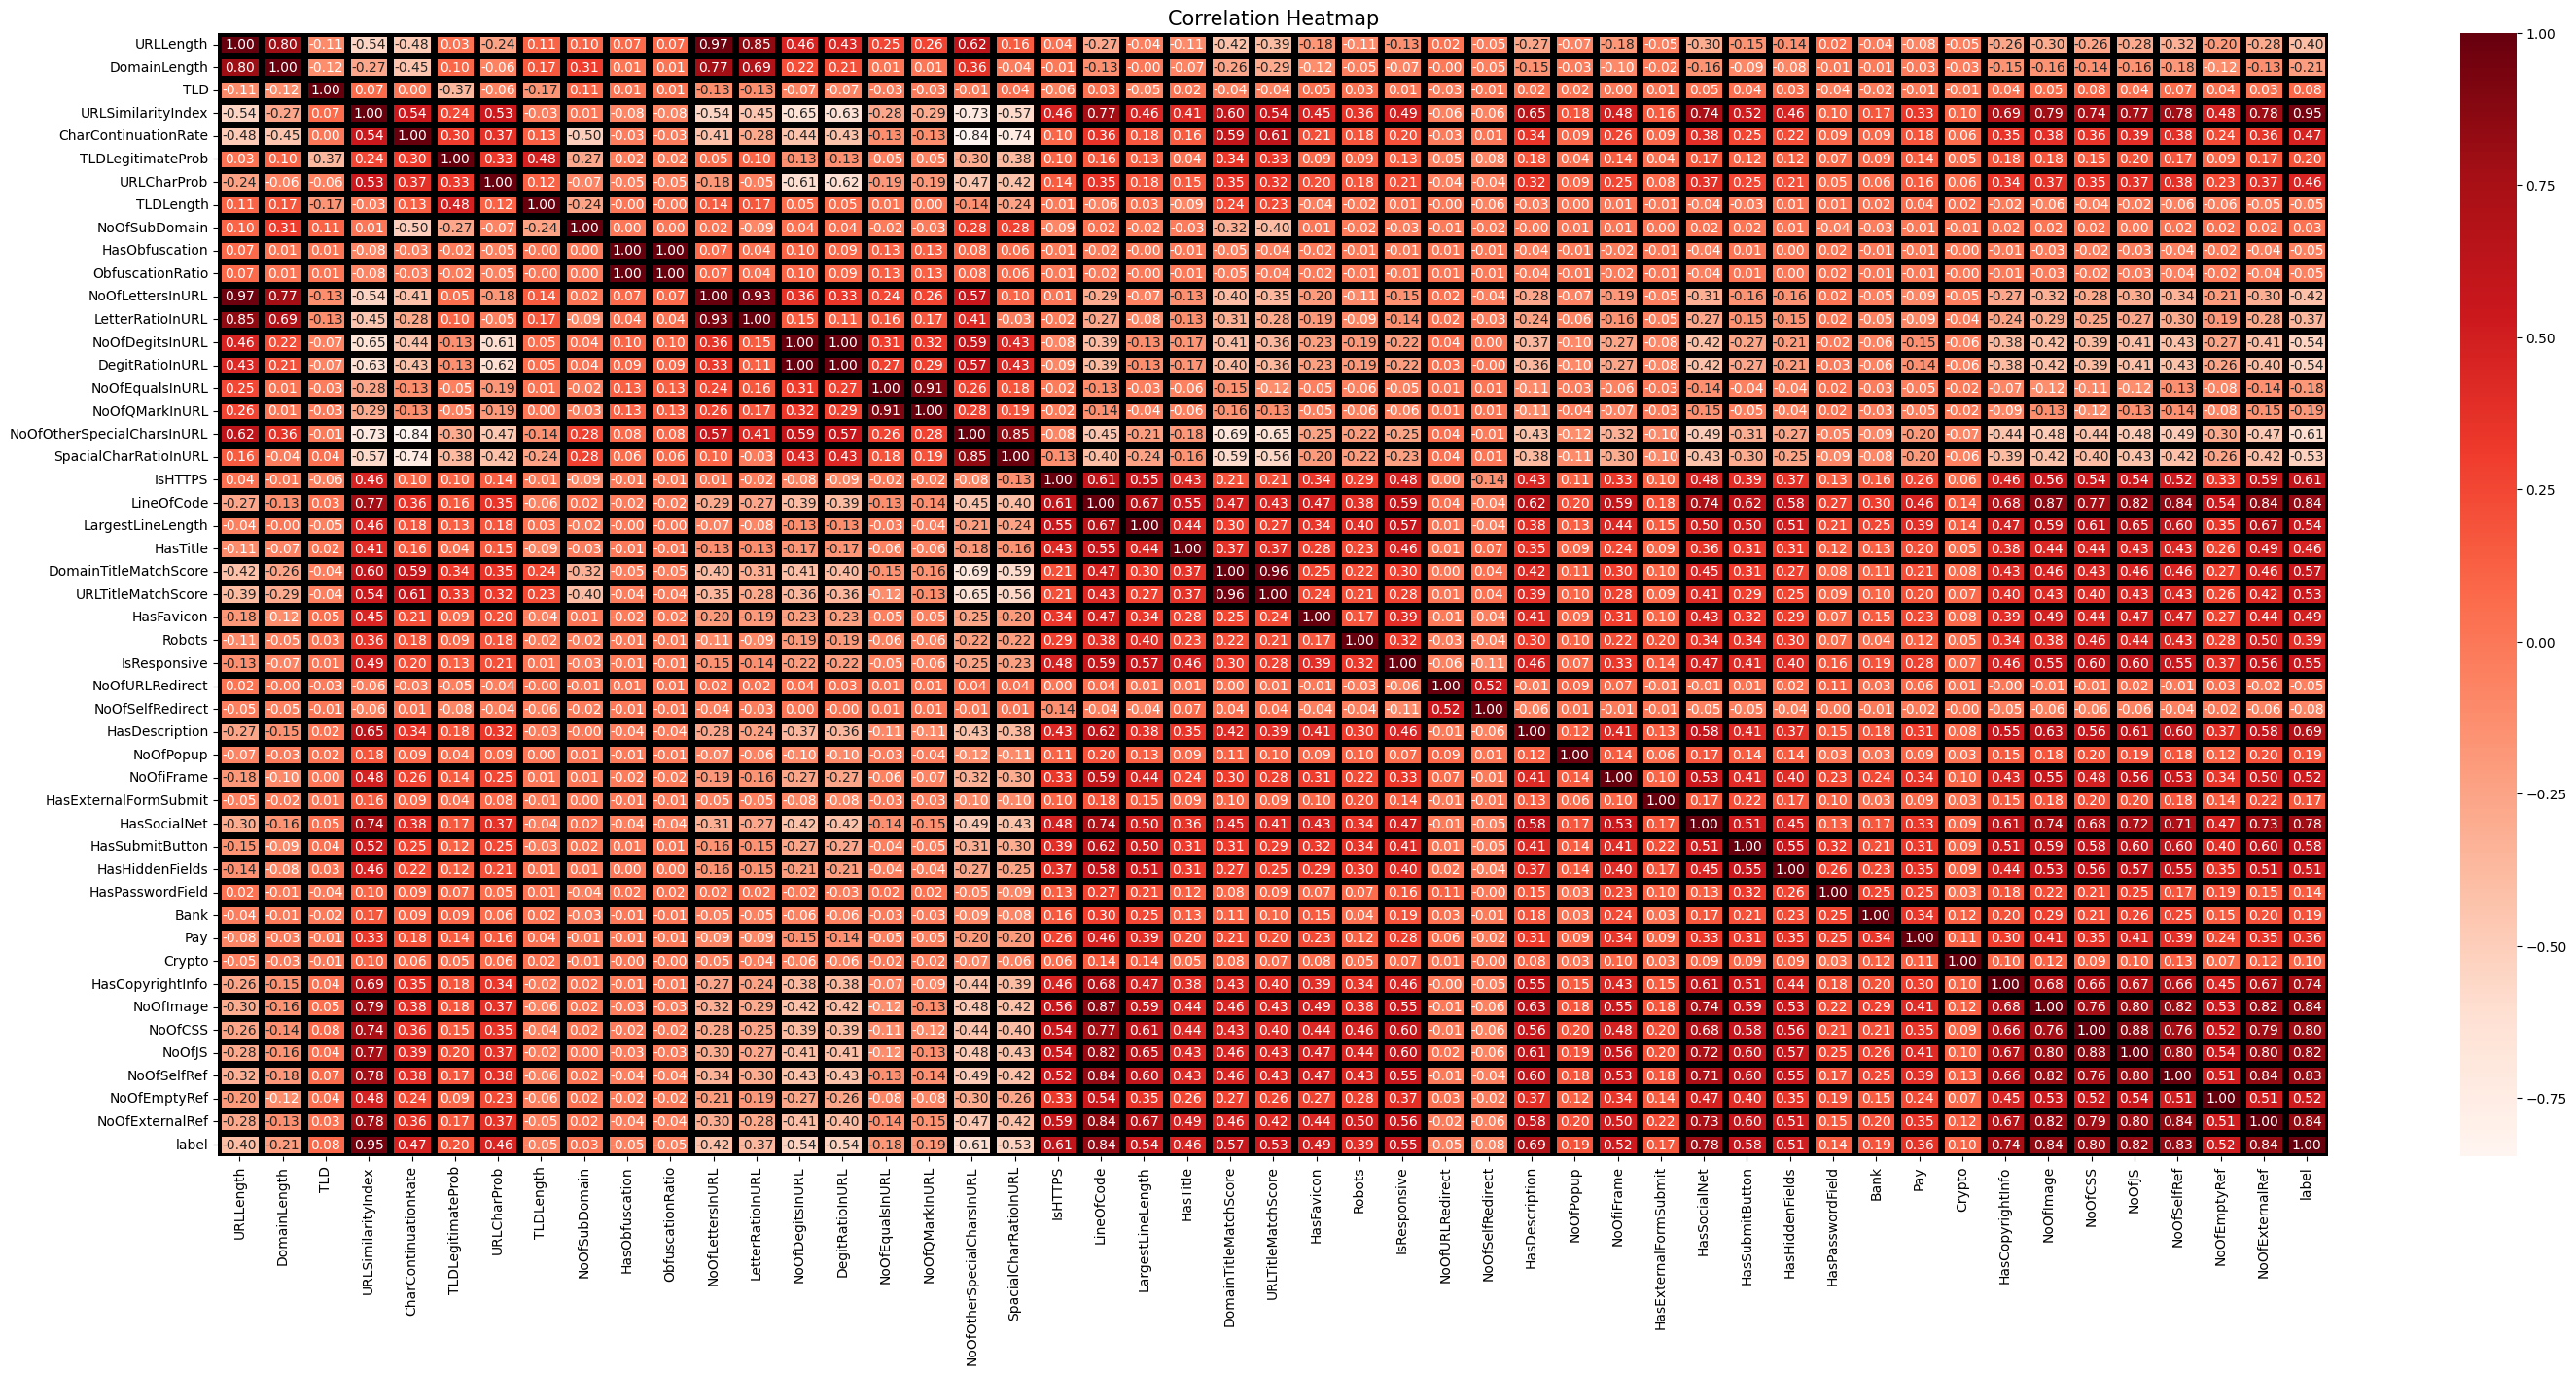

In [22]:
correlation_matrix = data.corr('spearman')

plt.figure(figsize=(35,15))
sns.heatmap(correlation_matrix, annot=True, cmap='Reds', fmt='.2f', linecolor='k', linewidths=5)
plt.title('Correlation Heatmap', fontsize=15)
plt.show()

In [23]:
correlation_with_label = correlation_matrix['label'].drop('label')

print(correlation_with_label)


URLLength                    -0.398683
DomainLength                 -0.213529
TLD                           0.082120
URLSimilarityIndex            0.945032
CharContinuationRate          0.470010
TLDLegitimateProb             0.197709
URLCharProb                   0.459111
TLDLength                    -0.054419
NoOfSubDomain                 0.033408
HasObfuscation               -0.052473
ObfuscationRatio             -0.052473
NoOfLettersInURL             -0.415633
LetterRatioInURL             -0.368834
NoOfDegitsInURL              -0.540799
DegitRatioInURL              -0.536274
NoOfEqualsInURL              -0.176950
NoOfQMarkInURL               -0.188822
NoOfOtherSpecialCharsInURL   -0.612520
SpacialCharRatioInURL        -0.527416
IsHTTPS                       0.609132
LineOfCode                    0.840966
LargestLineLength             0.542265
HasTitle                      0.459725
DomainTitleMatchScore         0.569761
URLTitleMatchScore            0.525153
HasFavicon               

In [24]:
correlation_analysis(0.8)

('URLLength', 'DomainLength')
('URLLength', 'NoOfLettersInURL')
('URLLength', 'LetterRatioInURL')
('URLSimilarityIndex', 'label')
('CharContinuationRate', 'NoOfOtherSpecialCharsInURL')
('HasObfuscation', 'ObfuscationRatio')
('NoOfLettersInURL', 'LetterRatioInURL')
('NoOfDegitsInURL', 'DegitRatioInURL')
('NoOfEqualsInURL', 'NoOfQMarkInURL')
('NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL')
('LineOfCode', 'NoOfImage')
('LineOfCode', 'NoOfJS')
('LineOfCode', 'NoOfSelfRef')
('LineOfCode', 'NoOfExternalRef')
('LineOfCode', 'label')
('DomainTitleMatchScore', 'URLTitleMatchScore')
('NoOfImage', 'NoOfJS')
('NoOfImage', 'NoOfSelfRef')
('NoOfImage', 'NoOfExternalRef')
('NoOfImage', 'label')
('NoOfCSS', 'NoOfJS')
('NoOfCSS', 'label')
('NoOfJS', 'label')
('NoOfSelfRef', 'NoOfExternalRef')
('NoOfSelfRef', 'label')
('NoOfExternalRef', 'label')


In [25]:
data_fs_1.drop(columns=['URLLength', 'DomainLength', 'TLDLength', 'ObfuscationRatio', 'LetterRatioInURL', 'LineOfCode','NoOfImage', 'HasPasswordField','HasFavicon','DegitRatioInURL', 'URLCharProb','HasTitle' , 'CharContinuationRate', 'URLTitleMatchScore' , 'NoOfSubDomain',  'NoOfDegitsInURL', 'HasExternalFormSubmit', 'NoOfPopup', 'TLD','TLDLegitimateProb' ,'NoOfEqualsInURL', 'Bank', 'NoOfOtherSpecialCharsInURL', 'Crypto', 'NoOfQMarkInURL', 'NoOfSelfRedirect', 'NoOfURLRedirect', 'Pay', 'Robots'], axis=1, inplace=True )
data_fs_1.head()

,URLSimilarityIndex,HasObfuscation,NoOfLettersInURL,SpacialCharRatioInURL,IsHTTPS,LargestLineLength,DomainTitleMatchScore,IsResponsive,HasDescription,NoOfiFrame,HasSocialNet,HasSubmitButton,HasHiddenFields,HasCopyrightInfo,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,100.0,0,18,0.032,1,9381,0.000000,1,0,1,0,1,1,1,20,28,119,0,124,1
1,100.0,0,9,0.087,1,9381,55.555556,0,0,0,1,1,0,1,9,8,39,0,217,1
2,100.0,0,15,0.069,1,682,46.666667,1,1,0,0,1,1,1,2,7,42,2,5,1
3,100.0,0,13,0.038,1,26824,0.000000,1,0,12,1,1,1,1,27,15,22,1,31,1
4,100.0,0,20,0.030,1,28404,100.000000,1,1,2,1,1,1,1,15,34,72,1,85,1


In [ ]:
data_fs_1.shape

(235795, 20)

## SelectKBest based Feature Selection

In [26]:
top_features_from_kbest(data)

                  feature_name    score_value
3           URLSimilarityIndex  671857.021354
34                HasSocialNet  376744.060221
41            HasCopyrightInfo  291213.405607
30              HasDescription  214554.534151
19                     IsHTTPS  139101.470625
23       DomainTitleMatchScore  122616.776204
35             HasSubmitButton  118640.503918
27                IsResponsive  101521.680953
24          URLTitleMatchScore   96765.322906
18       SpacialCharRatioInURL   93831.344742
36             HasHiddenFields   81897.941275
25                  HasFavicon   75999.486238
6                  URLCharProb   66763.176874
4         CharContinuationRate   66032.204782
22                    HasTitle   63188.852835
14             DegitRatioInURL   54111.119075
26                      Robots   42971.692064
44                      NoOfJS   38226.328013
12            LetterRatioInURL   36886.020298
39                         Pay   35052.121795
17  NoOfOtherSpecialCharsInURL   3

In [ ]:
#select top 15 feature
data_fs_2.drop(columns=["DegitRatioInURL", "Robots","NoOfJS", "LetterRatioInURL", "Pay", "NoOfOtherSpecialCharsInURL", "NoOfSelfRef", "DomainLength", "NoOfImage", "LineOfCode", "NoOfExternalRef", "NoOfLettersInURL","URLLength", "NoOfiFrame", "Bank", "NoOfDegitsInURL", "NoOfQMarkInURL","HasExternalFormSubmit", "HasPasswordField", "NoOfEmptyRef", "Crypto", "TLDLegitimateProb", "TLDLength", "NoOfEqualsInURL", "NoOfSelfRedirect","NoOfCSS", "HasObfuscation", "NoOfPopup", "NoOfURLRedirect", "ObfuscationRatio", "LargestLineLength", "TLD", "NoOfSubDomain"
], axis=1, inplace=True)
data_fs_2.head()

,URLSimilarityIndex,CharContinuationRate,URLCharProb,SpacialCharRatioInURL,IsHTTPS,HasTitle,DomainTitleMatchScore,URLTitleMatchScore,HasFavicon,IsResponsive,HasDescription,HasSocialNet,HasSubmitButton,HasHiddenFields,HasCopyrightInfo,label
0,100.0,1.000000,0.061933,0.032,1,1,0.000000,0.000000,0,1,0,0,1,1,1,1
1,100.0,0.666667,0.050207,0.087,1,1,55.555556,55.555556,1,0,0,1,1,0,1,1
2,100.0,0.866667,0.064129,0.069,1,1,46.666667,46.666667,0,1,1,0,1,1,1,1
3,100.0,1.000000,0.057606,0.038,1,1,0.000000,0.000000,0,1,0,1,1,1,1,1
4,100.0,1.000000,0.059441,0.030,1,1,100.000000,100.000000,0,1,1,1,1,1,1,1


In [ ]:
data_fs_2.shape

(235795, 16)

## Recursive Feature Elimination

In [ ]:
selected_features, top_feature = top_feature_from_rfe(data)


        URLSimilarityIndex  NoOfLettersInURL  NoOfDegitsInURL  \
0               100.000000                18                0   
1               100.000000                 9                0   
2               100.000000                15                0   
3               100.000000                13                0   
4               100.000000                20                0   
...                    ...               ...              ...   
235790          100.000000                16                0   
235791          100.000000                14                0   
235792          100.000000                17                0   
235793           28.157537                39                3   
235794          100.000000                20                0   

        DegitRatioInURL  NoOfOtherSpecialCharsInURL  IsHTTPS  LineOfCode  \
0                 0.000                           1        1         558   
1                 0.000                           2        1       

In [ ]:
#Drop other features from data_fs_3 and keep only the selected features
data_fs_3 = data_fs_3[selected_features.tolist()+['label']]

In [ ]:
data_fs_3.head()

,URLSimilarityIndex,NoOfLettersInURL,NoOfDegitsInURL,DegitRatioInURL,NoOfOtherSpecialCharsInURL,IsHTTPS,LineOfCode,HasDescription,HasSocialNet,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfExternalRef,label
0,100.0,18,0,0.0,1,1,558,0,0,1,34,20,28,119,124,1
1,100.0,9,0,0.0,2,1,618,0,1,1,50,9,8,39,217,1
2,100.0,15,0,0.0,2,1,467,1,0,1,10,2,7,42,5,1
3,100.0,13,0,0.0,1,1,6356,0,1,1,3,27,15,22,31,1
4,100.0,20,0,0.0,1,1,6089,1,1,1,244,15,34,72,85,1


## Mutual Information based feature selection

In [ ]:
top_features_from_mi(data)

,feature_name,score_value
3,URLSimilarityIndex,0.680885
20,LineOfCode,0.601354
47,NoOfExternalRef,0.561077
42,NoOfImage,0.543528
45,NoOfSelfRef,0.528093
44,NoOfJS,0.501178
21,LargestLineLength,0.487926
43,NoOfCSS,0.445914
34,HasSocialNet,0.416831
12,LetterRatioInURL,0.382342


In [ ]:
def select_top_features(data, k=15):

    top_features = top_features_from_mi(data)
    top_feature_names = top_features['feature_name'].head(k).tolist()

    # Include the target variable
    top_feature_names.append('label')

    selected_data = data[top_feature_names]

    return selected_data

In [ ]:
data_fs_4 = select_top_features(data)
data_fs_4.head()

,URLSimilarityIndex,LineOfCode,NoOfExternalRef,NoOfImage,NoOfSelfRef,NoOfJS,LargestLineLength,NoOfCSS,HasSocialNet,LetterRatioInURL,HasCopyrightInfo,HasDescription,IsHTTPS,NoOfOtherSpecialCharsInURL,DomainTitleMatchScore,label
0,100.0,558,124,34,119,28,9381,20,0,0.581,1,0,1,1,0.000000,1
1,100.0,618,217,50,39,8,9381,9,1,0.391,1,0,1,2,55.555556,1
2,100.0,467,5,10,42,7,682,2,0,0.517,1,1,1,2,46.666667,1
3,100.0,6356,31,3,22,15,26824,27,1,0.500,1,0,1,1,0.000000,1
4,100.0,6089,85,244,72,34,28404,15,1,0.606,1,1,1,1,100.000000,1


## Feature importance using RF

In [ ]:
data_fs_5=top_features_from_importance(data)
data_fs_5.head()

['URLSimilarityIndex' 'NoOfExternalRef' 'NoOfImage' 'NoOfSelfRef'
 'LineOfCode' 'NoOfCSS' 'HasSocialNet' 'NoOfJS' 'LargestLineLength'
 'HasCopyrightInfo' 'HasDescription' 'NoOfOtherSpecialCharsInURL'
 'IsHTTPS' 'DegitRatioInURL' 'DomainTitleMatchScore']


,URLSimilarityIndex,NoOfExternalRef,NoOfImage,NoOfSelfRef,LineOfCode,NoOfCSS,HasSocialNet,NoOfJS,LargestLineLength,HasCopyrightInfo,HasDescription,NoOfOtherSpecialCharsInURL,IsHTTPS,DegitRatioInURL,DomainTitleMatchScore,label
0,100.0,124,34,119,558,20,0,28,9381,1,0,1,1,0.0,0.000000,1
1,100.0,217,50,39,618,9,1,8,9381,1,0,2,1,0.0,55.555556,1
2,100.0,5,10,42,467,2,0,7,682,1,1,2,1,0.0,46.666667,1
3,100.0,31,3,22,6356,27,1,15,26824,1,0,1,1,0.0,0.000000,1
4,100.0,85,244,72,6089,15,1,34,28404,1,1,1,1,0.0,100.000000,1


## Feature importance using LR

In [ ]:
data_fs_6=top_features_from_lr_importance(data)
data_fs_6.head()

['IsHTTPS' 'DomainLength' 'URLLength' 'TLDLength' 'HasDescription'
 'HasCopyrightInfo' 'NoOfOtherSpecialCharsInURL' 'HasSocialNet'
 'CharContinuationRate' 'NoOfDegitsInURL' 'HasFavicon'
 'DomainTitleMatchScore' 'URLTitleMatchScore' 'NoOfiFrame'
 'HasHiddenFields']


,IsHTTPS,DomainLength,URLLength,TLDLength,HasDescription,HasCopyrightInfo,NoOfOtherSpecialCharsInURL,HasSocialNet,CharContinuationRate,NoOfDegitsInURL,HasFavicon,DomainTitleMatchScore,URLTitleMatchScore,NoOfiFrame,HasHiddenFields,label
0,1,24,31,3,0,1,1,0,1.000000,0,0,0.000000,0.000000,1,1,1
1,1,16,23,2,0,1,2,1,0.666667,0,1,55.555556,55.555556,0,0,1
2,1,22,29,2,1,1,2,0,0.866667,0,0,46.666667,46.666667,0,1,1
3,1,19,26,3,0,1,1,1,1.000000,0,0,0.000000,0.000000,12,1,1
4,1,26,33,3,1,1,1,1,1.000000,0,0,100.000000,100.000000,2,1,1


## Sequential Feature Selection

In [ ]:
data_fs_7=top_features_from_sfs(data)
data_fs_7.head()

['URLLength', 'TLD', 'URLSimilarityIndex', 'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'HasObfuscation', 'ObfuscationRatio', 'LetterRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'IsHTTPS', 'DomainTitleMatchScore', 'URLTitleMatchScore', 'Robots', 'label']


,URLLength,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,HasObfuscation,ObfuscationRatio,LetterRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,IsHTTPS,DomainTitleMatchScore,URLTitleMatchScore,Robots,label
0,31,231,100.0,1.000000,0.522907,0.061933,0,0.0,0.581,0,0,1,0.000000,0.000000,1,1
1,23,254,100.0,0.666667,0.032650,0.050207,0,0.0,0.391,0,0,1,55.555556,55.555556,1,1
2,29,647,100.0,0.866667,0.028555,0.064129,0,0.0,0.517,0,0,1,46.666667,46.666667,1,1
3,26,231,100.0,1.000000,0.522907,0.057606,0,0.0,0.500,0,0,1,0.000000,0.000000,1,1
4,33,503,100.0,1.000000,0.079963,0.059441,0,0.0,0.606,0,0,1,100.000000,100.000000,1,1


## PCA

In [27]:
data_pcaV_8 = top_features_from_pca(data)


Selected 26 components to retain 95% variance.
Explained Variance Ratio of Selected Components: 0.8543717382669145


In [28]:
data_pcaV_8.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,label
0,1.372553,0.536652,0.109462,1.553042,-0.640955,0.393624,0.418166,-0.297436,-0.125060,-0.975547,...,-1.071449,-0.365510,0.448943,-1.607634,-0.957294,1.367685,1.019747,0.342322,-1.098958,1
1,0.888899,-0.123947,1.261637,-1.569305,-0.179512,-0.290666,0.725498,0.055319,0.989952,0.255421,...,-0.017085,-0.642714,-0.427791,0.367521,-0.392494,0.721007,0.170604,-0.396862,-0.503056,1
2,1.094984,0.231753,1.963324,-1.696133,-1.679189,0.015079,0.324327,1.169488,-0.404549,-0.635574,...,-0.267088,-1.031865,0.214936,-0.023110,-0.964291,1.031944,0.128186,0.852535,0.064120,1
3,2.457068,0.967803,0.528385,1.543598,0.133034,0.336105,0.186314,-0.836501,-0.631406,-1.024196,...,-1.894082,-1.561939,-1.327105,0.965462,-0.286467,1.086684,-0.843107,0.807209,2.178948,1
4,3.722673,1.675144,0.773165,1.112597,2.800897,-0.416069,-2.849077,3.404304,0.368956,0.220718,...,-0.803785,0.722125,0.396015,-1.581474,0.341699,1.696497,1.402053,2.460481,-0.662468,1


# Outlier Detection

In [ ]:
# Remove outliers
data_fs_1_no_outliers = remove_outliers_iqr(data_fs_1)

# Display the result
print("Dataset1 shape:", data_fs_1.shape)
print("Dataset1 shape after removing outliers using IQR method:", data_fs_1_no_outliers.shape)

Dataset1 shape: (235795, 20)
Dataset1 shape after removing outliers using IQR method: (84680, 20)


In [ ]:
# Remove outliers
data_fs_2_no_outliers = remove_outliers_iqr(data_fs_2)

# Display the result
print("Dataset1 shape:", data_fs_2.shape)
print("Dataset1 shape after removing outliers using IQR method:", data_fs_2_no_outliers.shape)

Dataset1 shape: (235795, 16)
Dataset1 shape after removing outliers using IQR method: (168103, 16)


In [ ]:
# Remove outliers
data_fs_3_no_outliers = remove_outliers_iqr(data_fs_3)

# Display the result
print("Dataset1 shape:", data_fs_3.shape)
print("Dataset1 shape after removing outliers using IQR method:", data_fs_3_no_outliers.shape)

Dataset1 shape: (235795, 16)
Dataset1 shape after removing outliers using IQR method: (90949, 16)


In [ ]:
# Remove outliers
data_fs_4_no_outliers = remove_outliers_iqr(data_fs_4)

# Display the result
print("Dataset1 shape:", data_fs_4.shape)
print("Dataset1 shape after removing outliers using IQR method:", data_fs_4_no_outliers.shape)

Dataset1 shape: (235795, 16)
Dataset1 shape after removing outliers using IQR method: (114027, 16)


In [ ]:
# Remove outliers
data_fs_5_no_outliers = remove_outliers_iqr(data_fs_5)

# Display the result
print("Dataset2 shape:", data_fs_5.shape)
print("Dataset2 shape after removing outliers using IQR method:", data_fs_5_no_outliers.shape)

Dataset2 shape: (235795, 16)
Dataset2 shape after removing outliers using IQR method: (90421, 16)


In [ ]:
# Remove outliers
data_fs_6_no_outliers = remove_outliers_iqr(data_fs_6)

# Display the result
print("Dataset2 shape:", data_fs_6.shape)
print("Dataset2 shape after removing outliers using IQR method:", data_fs_6_no_outliers.shape)

Dataset2 shape: (235795, 16)
Dataset2 shape after removing outliers using IQR method: (110147, 16)


In [ ]:
# Remove outliers
data_fs_7_no_outliers = remove_outliers_iqr(data_fs_7)

# Display the result
print("Dataset2 shape:", data_fs_7.shape)
print("Dataset2 shape after removing outliers using IQR method:", data_fs_7_no_outliers.shape)

Dataset2 shape: (235795, 16)
Dataset2 shape after removing outliers using IQR method: (164007, 16)


In [29]:
# Remove outliers
data_pcaV_8_no_outliers = remove_outliers_iqr(data_pcaV_8)

# Display the result
print("Dataset2 shape:", data_pcaV_8.shape)
print("Dataset2 shape after removing outliers using IQR method:", data_pcaV_8_no_outliers.shape)

Dataset2 shape: (235795, 27)
Dataset2 shape after removing outliers using IQR method: (135302, 27)


# Evaluation under Traditional Supervised learning

## Model Evaluation on Primary dataset

In [ ]:
X_train, X_test, y_train, y_test = datapartition(data)

In [ ]:
classification_metrics(X_train, X_test, y_train, y_test)

--- label-propagation ---
Accuracy: 0.9954
Precision: 0.9954
Recall: 0.9954
F-Measure: 0.9954

--- KNeighbors ---
Accuracy: 0.9961
Precision: 0.9961
Recall: 0.9961
F-Measure: 0.9961

--- Random Forest ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Gradient Boosting ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Logistic Regression ---
Accuracy: 0.9969
Precision: 0.9969
Recall: 0.9969
F-Measure: 0.9969

--- Decision Tree ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Naive Bayes ---
Accuracy: 0.9818
Precision: 0.9825
Recall: 0.9818
F-Measure: 0.9818

--- AdaBoost ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Linear SVC ---
Accuracy: 0.9968
Precision: 0.9968
Recall: 0.9968
F-Measure: 0.9968



##  Model evaluation after feature selection

In [ ]:
X_train_data_fs_1, X_test_data_fs_1, y_train_data_fs_1, y_test_data_fs_1 = datapartition(data_fs_1)
X_train_data_fs_2, X_test_data_fs_2, y_train_data_fs_2, y_test_data_fs_2 = datapartition(data_fs_2)
X_train_data_fs_3, X_test_data_fs_3, y_train_data_fs_3, y_test_data_fs_3 = datapartition(data_fs_3)
X_train_data_fs_4, X_test_data_fs_4, y_train_data_fs_4, y_test_data_fs_4 = datapartition(data_fs_4)
X_train_data_fs_5, X_test_data_fs_5, y_train_data_fs_5, y_test_data_fs_5 = datapartition(data_fs_5)
X_train_data_fs_6, X_test_data_fs_6, y_train_data_fs_6, y_test_data_fs_6 = datapartition(data_fs_6)

In [ ]:
X_train_data_fs_7, X_test_data_fs_7, y_train_data_fs_7, y_test_data_fs_7 = datapartition(data_fs_7)

In [ ]:
classification_metrics(X_train_data_fs_1, X_test_data_fs_1, y_train_data_fs_1, y_test_data_fs_1)

--- label-propagation ---
Accuracy: 0.9942
Precision: 0.9942
Recall: 0.9942
F-Measure: 0.9942

--- KNeighbors ---
Accuracy: 0.9959
Precision: 0.9959
Recall: 0.9959
F-Measure: 0.9959

--- Random Forest ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Gradient Boosting ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Logistic Regression ---
Accuracy: 0.9853
Precision: 0.9854
Recall: 0.9853
F-Measure: 0.9853

--- Decision Tree ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Naive Bayes ---
Accuracy: 0.9657
Precision: 0.9682
Recall: 0.9657
F-Measure: 0.9658

--- AdaBoost ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Linear SVC ---
Accuracy: 0.9848
Precision: 0.9849
Recall: 0.9848
F-Measure: 0.9848



In [ ]:
classification_metrics(X_train_data_fs_2, X_test_data_fs_2, y_train_data_fs_2, y_test_data_fs_2)

--- label-propagation ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F-Measure: 0.9997

--- KNeighbors ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Random Forest ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Gradient Boosting ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Logistic Regression ---
Accuracy: 0.9993
Precision: 0.9993
Recall: 0.9993
F-Measure: 0.9993

--- Decision Tree ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Naive Bayes ---
Accuracy: 0.9992
Precision: 0.9992
Recall: 0.9992
F-Measure: 0.9992

--- AdaBoost ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Linear SVC ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F-Measure: 0.9997



In [ ]:
classification_metrics(X_train_data_fs_3, X_test_data_fs_3, y_train_data_fs_3, y_test_data_fs_3)

--- label-propagation ---
Accuracy: 0.9993
Precision: 0.9993
Recall: 0.9993
F-Measure: 0.9993

--- KNeighbors ---
Accuracy: 0.9995
Precision: 0.9995
Recall: 0.9995
F-Measure: 0.9995

--- Random Forest ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Gradient Boosting ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Logistic Regression ---
Accuracy: 0.9973
Precision: 0.9973
Recall: 0.9973
F-Measure: 0.9973

--- Decision Tree ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Naive Bayes ---
Accuracy: 0.9989
Precision: 0.9989
Recall: 0.9989
F-Measure: 0.9989

--- AdaBoost ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Linear SVC ---
Accuracy: 0.9964
Precision: 0.9964
Recall: 0.9964
F-Measure: 0.9964



In [ ]:
classification_metrics(X_train_data_fs_4, X_test_data_fs_4, y_train_data_fs_4, y_test_data_fs_4)

--- label-propagation ---
Accuracy: 0.9968
Precision: 0.9968
Recall: 0.9968
F-Measure: 0.9968

--- KNeighbors ---
Accuracy: 0.9977
Precision: 0.9977
Recall: 0.9977
F-Measure: 0.9977

--- Random Forest ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Gradient Boosting ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Logistic Regression ---
Accuracy: 0.9958
Precision: 0.9958
Recall: 0.9958
F-Measure: 0.9958

--- Decision Tree ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Naive Bayes ---
Accuracy: 0.9686
Precision: 0.9707
Recall: 0.9686
F-Measure: 0.9688

--- AdaBoost ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Linear SVC ---
Accuracy: 0.9926
Precision: 0.9926
Recall: 0.9926
F-Measure: 0.9926



In [ ]:
classification_metrics(X_train_data_fs_5, X_test_data_fs_5, y_train_data_fs_5, y_test_data_fs_5)

--- label-propagation ---


KeyboardInterrupt: 

In [ ]:
classification_metrics(X_train_data_fs_6, X_test_data_fs_6, y_train_data_fs_6, y_test_data_fs_6)

In [ ]:
classification_metrics(X_train_data_fs_7, X_test_data_fs_7, y_train_data_fs_7, y_test_data_fs_7)

## Model evaluation after feature selection & outlier detection

In [ ]:

X_train_data1, X_test_data1, y_train_data1, y_test_data1 = datapartition(data_fs_1_no_outliers)
X_train_data2, X_test_data2, y_train_data2, y_test_data2 = datapartition(data_fs_2_no_outliers)
X_train_data3, X_test_data3, y_train_data3, y_test_data3 = datapartition(data_fs_3_no_outliers)
X_train_data4, X_test_data4, y_train_data4, y_test_data4 = datapartition(data_fs_4_no_outliers)
X_train_data5, X_test_data5, y_train_data5, y_test_data5 = datapartition(data_fs_5_no_outliers)
X_train_data6, X_test_data6, y_train_data6, y_test_data6 = datapartition(data_fs_6_no_outliers)
X_train_data7, X_test_data7, y_train_data7, y_test_data7 = datapartition(data_fs_7_no_outliers)

In [ ]:
classification_metrics(X_train_data1, X_test_data1, y_train_data1, y_test_data1)

--- label-propagation ---
Accuracy: 0.9950
Precision: 0.9950
Recall: 0.9950
F-Measure: 0.9950

--- KNeighbors ---
Accuracy: 0.9969
Precision: 0.9969
Recall: 0.9969
F-Measure: 0.9969

--- Random Forest ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Gradient Boosting ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Logistic Regression ---
Accuracy: 0.9887
Precision: 0.9887
Recall: 0.9887
F-Measure: 0.9887

--- Decision Tree ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Naive Bayes ---
Accuracy: 0.9995
Precision: 0.9995
Recall: 0.9995
F-Measure: 0.9995

--- AdaBoost ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Linear SVC ---
Accuracy: 0.9870
Precision: 0.9869
Recall: 0.9870
F-Measure: 0.9869



In [ ]:
classification_metrics(X_train_data2, X_test_data2, y_train_data2, y_test_data2)

--- label-propagation ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- KNeighbors ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Random Forest ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Gradient Boosting ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Logistic Regression ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F-Measure: 0.9997

--- Decision Tree ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Naive Bayes ---
Accuracy: 0.9989
Precision: 0.9989
Recall: 0.9989
F-Measure: 0.9989

--- AdaBoost ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Linear SVC ---
Accuracy: 0.9994
Precision: 0.9994
Recall: 0.9994
F-Measure: 0.9994



In [ ]:
classification_metrics(X_train_data3, X_test_data3, y_train_data3, y_test_data3)

--- label-propagation ---
Accuracy: 0.9994
Precision: 0.9994
Recall: 0.9994
F-Measure: 0.9994

--- KNeighbors ---
Accuracy: 0.9994
Precision: 0.9994
Recall: 0.9994
F-Measure: 0.9994

--- Random Forest ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Gradient Boosting ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Logistic Regression ---
Accuracy: 0.9987
Precision: 0.9987
Recall: 0.9987
F-Measure: 0.9987

--- Decision Tree ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Naive Bayes ---
Accuracy: 0.9996
Precision: 0.9996
Recall: 0.9996
F-Measure: 0.9996

--- AdaBoost ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Linear SVC ---
Accuracy: 0.9989
Precision: 0.9989
Recall: 0.9989
F-Measure: 0.9989



In [ ]:
classification_metrics(X_train_data4, X_test_data4, y_train_data4, y_test_data4)

--- label-propagation ---
Accuracy: 0.9961
Precision: 0.9961
Recall: 0.9961
F-Measure: 0.9961

--- KNeighbors ---
Accuracy: 0.9971
Precision: 0.9971
Recall: 0.9971
F-Measure: 0.9971

--- Random Forest ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Gradient Boosting ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Logistic Regression ---
Accuracy: 0.9981
Precision: 0.9981
Recall: 0.9981
F-Measure: 0.9981

--- Decision Tree ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Naive Bayes ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F-Measure: 0.9997

--- AdaBoost ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Linear SVC ---
Accuracy: 0.9987
Precision: 0.9987
Recall: 0.9987
F-Measure: 0.9987



In [ ]:
classification_metrics(X_train_data5, X_test_data5, y_train_data5, y_test_data5)

--- label-propagation ---
Accuracy: 0.9977
Precision: 0.9977
Recall: 0.9977
F-Measure: 0.9977

--- KNeighbors ---
Accuracy: 0.9978
Precision: 0.9978
Recall: 0.9978
F-Measure: 0.9978

--- Random Forest ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Gradient Boosting ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Logistic Regression ---
Accuracy: 0.9981
Precision: 0.9981
Recall: 0.9981
F-Measure: 0.9981

--- Decision Tree ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Naive Bayes ---
Accuracy: 0.9992
Precision: 0.9992
Recall: 0.9992
F-Measure: 0.9992

--- AdaBoost ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Linear SVC ---
Accuracy: 0.9961
Precision: 0.9961
Recall: 0.9961
F-Measure: 0.9961



In [ ]:
classification_metrics(X_train_data6, X_test_data6, y_train_data6, y_test_data6)

--- label-propagation ---
Accuracy: 0.9940
Precision: 0.9939
Recall: 0.9940
F-Measure: 0.9939

--- KNeighbors ---
Accuracy: 0.9945
Precision: 0.9944
Recall: 0.9945
F-Measure: 0.9944

--- Random Forest ---
Accuracy: 0.9939
Precision: 0.9939
Recall: 0.9939
F-Measure: 0.9939

--- Gradient Boosting ---
Accuracy: 0.9903
Precision: 0.9903
Recall: 0.9903
F-Measure: 0.9903

--- Logistic Regression ---
Accuracy: 0.9954
Precision: 0.9954
Recall: 0.9954
F-Measure: 0.9954

--- Decision Tree ---
Accuracy: 0.9916
Precision: 0.9916
Recall: 0.9916
F-Measure: 0.9916

--- Naive Bayes ---
Accuracy: 0.9801
Precision: 0.9804
Recall: 0.9801
F-Measure: 0.9802

--- AdaBoost ---
Accuracy: 0.9886
Precision: 0.9885
Recall: 0.9886
F-Measure: 0.9885

--- Linear SVC ---
Accuracy: 0.9957
Precision: 0.9957
Recall: 0.9957
F-Measure: 0.9957



In [ ]:
classification_metrics(X_train_data7, X_test_data7, y_train_data7, y_test_data7)

--- label-propagation ---
Accuracy: 0.9996
Precision: 0.9996
Recall: 0.9996
F-Measure: 0.9996

--- KNeighbors ---
Accuracy: 0.9996
Precision: 0.9996
Recall: 0.9996
F-Measure: 0.9996

--- Random Forest ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Gradient Boosting ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Logistic Regression ---
Accuracy: 0.9994
Precision: 0.9994
Recall: 0.9994
F-Measure: 0.9994

--- Decision Tree ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F-Measure: 0.9997

--- Naive Bayes ---
Accuracy: 0.9994
Precision: 0.9994
Recall: 0.9994
F-Measure: 0.9994

--- AdaBoost ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F-Measure: 0.9997

--- Linear SVC ---
Accuracy: 0.9986
Precision: 0.9986
Recall: 0.9986
F-Measure: 0.9986



##Model Evaluations after feature transformation

In [ ]:

X_train_scaled, X_test_scaled =z_score_tranformation(X_train, X_test)
X_train_scaled_data1, X_test_scaled_data1 =z_score_tranformation(X_train_data1, X_test_data1)
X_train_scaled_data2, X_test_scaled_data2 =z_score_tranformation(X_train_data2, X_test_data2)
X_train_scaled_data3, X_test_scaled_data3 =z_score_tranformation(X_train_data3, X_test_data3)
X_train_scaled_data4, X_test_scaled_data4 =z_score_tranformation(X_train_data4, X_test_data4)
X_train_scaled_data5, X_test_scaled_data5 =z_score_tranformation(X_train_data5, X_test_data5)
X_train_scaled_data6, X_test_scaled_data6 =z_score_tranformation(X_train_data6, X_test_data6)
X_train_scaled_data7, X_test_scaled_data7 =z_score_tranformation(X_train_data7, X_test_data7)

In [ ]:
classification_metrics(X_train_scaled, X_test_scaled, y_train, y_test)

--- label-propagation ---
Accuracy: 0.9984
Precision: 0.9984
Recall: 0.9984
F-Measure: 0.9984

--- KNeighbors ---
Accuracy: 0.9986
Precision: 0.9986
Recall: 0.9986
F-Measure: 0.9986

--- Random Forest ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Gradient Boosting ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Logistic Regression ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Decision Tree ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Naive Bayes ---
Accuracy: 0.9996
Precision: 0.9996
Recall: 0.9996
F-Measure: 0.9996

--- AdaBoost ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Linear SVC ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000



In [ ]:
classification_metrics(X_train_scaled_data1, X_test_scaled_data1, y_train_data1, y_test_data1)

--- label-propagation ---
Accuracy: 0.9983
Precision: 0.9983
Recall: 0.9983
F-Measure: 0.9983

--- KNeighbors ---
Accuracy: 0.9987
Precision: 0.9987
Recall: 0.9987
F-Measure: 0.9987

--- Random Forest ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Gradient Boosting ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Logistic Regression ---
Accuracy: 0.9996
Precision: 0.9996
Recall: 0.9996
F-Measure: 0.9996

--- Decision Tree ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Naive Bayes ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- AdaBoost ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Linear SVC ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998



In [ ]:
classification_metrics(X_train_scaled_data2, X_test_scaled_data2, y_train_data2, y_test_data2)

--- label-propagation ---
Accuracy: 0.9985
Precision: 0.9985
Recall: 0.9985
F-Measure: 0.9985

--- KNeighbors ---
Accuracy: 0.9986
Precision: 0.9986
Recall: 0.9986
F-Measure: 0.9986

--- Random Forest ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Gradient Boosting ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Logistic Regression ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F-Measure: 0.9997

--- Decision Tree ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Naive Bayes ---
Accuracy: 0.9990
Precision: 0.9990
Recall: 0.9990
F-Measure: 0.9990

--- AdaBoost ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Linear SVC ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998



In [ ]:
classification_metrics(X_train_scaled_data3, X_test_scaled_data3, y_train_data3, y_test_data3)

--- label-propagation ---
Accuracy: 0.9996
Precision: 0.9996
Recall: 0.9996
F-Measure: 0.9996

--- KNeighbors ---
Accuracy: 0.9996
Precision: 0.9996
Recall: 0.9996
F-Measure: 0.9996

--- Random Forest ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Gradient Boosting ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Logistic Regression ---
Accuracy: 0.9996
Precision: 0.9996
Recall: 0.9996
F-Measure: 0.9996

--- Decision Tree ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Naive Bayes ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- AdaBoost ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Linear SVC ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999



In [ ]:
classification_metrics(X_train_scaled_data4, X_test_scaled_data4, y_train_data4, y_test_data4)

--- label-propagation ---
Accuracy: 0.9995
Precision: 0.9995
Recall: 0.9995
F-Measure: 0.9995

--- KNeighbors ---
Accuracy: 0.9996
Precision: 0.9996
Recall: 0.9996
F-Measure: 0.9996

--- Random Forest ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Gradient Boosting ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Logistic Regression ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Decision Tree ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Naive Bayes ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F-Measure: 0.9997

--- AdaBoost ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Linear SVC ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999



In [ ]:
classification_metrics(X_train_scaled_data5, X_test_scaled_data5, y_train_data5, y_test_data5)

--- label-propagation ---
Accuracy: 0.9996
Precision: 0.9996
Recall: 0.9996
F-Measure: 0.9996

--- KNeighbors ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Random Forest ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Gradient Boosting ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Logistic Regression ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Decision Tree ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Naive Bayes ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- AdaBoost ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Linear SVC ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000



In [ ]:
classification_metrics(X_train_scaled_data6, X_test_scaled_data6, y_train_data6, y_test_data6)

--- label-propagation ---
Accuracy: 0.9918
Precision: 0.9918
Recall: 0.9918
F-Measure: 0.9918

--- KNeighbors ---
Accuracy: 0.9917
Precision: 0.9917
Recall: 0.9917
F-Measure: 0.9917

--- Random Forest ---
Accuracy: 0.9939
Precision: 0.9939
Recall: 0.9939
F-Measure: 0.9939

--- Gradient Boosting ---
Accuracy: 0.9903
Precision: 0.9903
Recall: 0.9903
F-Measure: 0.9903

--- Logistic Regression ---
Accuracy: 0.9957
Precision: 0.9957
Recall: 0.9957
F-Measure: 0.9957

--- Decision Tree ---
Accuracy: 0.9916
Precision: 0.9916
Recall: 0.9916
F-Measure: 0.9916

--- Naive Bayes ---
Accuracy: 0.9801
Precision: 0.9804
Recall: 0.9801
F-Measure: 0.9802

--- AdaBoost ---
Accuracy: 0.9886
Precision: 0.9885
Recall: 0.9886
F-Measure: 0.9885

--- Linear SVC ---
Accuracy: 0.9965
Precision: 0.9965
Recall: 0.9965
F-Measure: 0.9965



In [ ]:
classification_metrics(X_train_scaled_data7, X_test_scaled_data7, y_train_data7, y_test_data7)

--- label-propagation ---
Accuracy: 0.9991
Precision: 0.9991
Recall: 0.9991
F-Measure: 0.9991

--- KNeighbors ---
Accuracy: 0.9993
Precision: 0.9993
Recall: 0.9993
F-Measure: 0.9993

--- Random Forest ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Gradient Boosting ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Logistic Regression ---
Accuracy: 0.9996
Precision: 0.9996
Recall: 0.9996
F-Measure: 0.9996

--- Decision Tree ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F-Measure: 0.9997

--- Naive Bayes ---
Accuracy: 0.9995
Precision: 0.9995
Recall: 0.9995
F-Measure: 0.9995

--- AdaBoost ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F-Measure: 0.9997

--- Linear SVC ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F-Measure: 0.9997



In [ ]:
X_train_mxscaled, X_test_mxscaled =min_max_tranformation(X_train, X_test)
X_train_mxscaled_data1, X_test_mxscaled_data1 =min_max_tranformation(X_train_data1, X_test_data1)
X_train_mxscaled_data2, X_test_mxscaled_data2 =min_max_tranformation(X_train_data2, X_test_data2)
X_train_mxscaled_data3, X_test_mxscaled_data3 =min_max_tranformation(X_train_data3, X_test_data3)
X_train_mxscaled_data4, X_test_mxscaled_data4 =min_max_tranformation(X_train_data4, X_test_data4)
X_train_mxscaled_data5, X_test_mxscaled_data5 =min_max_tranformation(X_train_data5, X_test_data5)
X_train_mxscaled_data6, X_test_mxscaled_data6 =min_max_tranformation(X_train_data6, X_test_data6)
X_train_mxscaled_data7, X_test_mxscaled_data7 =min_max_tranformation(X_train_data7, X_test_data7)

In [ ]:
classification_metrics(X_train_mxscaled, X_test_mxscaled, y_train, y_test)

--- label-propagation ---
Accuracy: 0.9956
Precision: 0.9956
Recall: 0.9956
F-Measure: 0.9956

--- KNeighbors ---
Accuracy: 0.9963
Precision: 0.9963
Recall: 0.9963
F-Measure: 0.9963

--- Random Forest ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Gradient Boosting ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Logistic Regression ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F-Measure: 0.9997

--- Decision Tree ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Naive Bayes ---
Accuracy: 0.9996
Precision: 0.9996
Recall: 0.9996
F-Measure: 0.9996

--- AdaBoost ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Linear SVC ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999



In [ ]:
classification_metrics(X_train_mxscaled_data1, X_test_mxscaled_data1, y_train_data1, y_test_data1)

--- label-propagation ---
Accuracy: 0.9976
Precision: 0.9976
Recall: 0.9976
F-Measure: 0.9976

--- KNeighbors ---
Accuracy: 0.9982
Precision: 0.9982
Recall: 0.9982
F-Measure: 0.9982

--- Random Forest ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Gradient Boosting ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Logistic Regression ---
Accuracy: 0.9996
Precision: 0.9996
Recall: 0.9996
F-Measure: 0.9996

--- Decision Tree ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Naive Bayes ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- AdaBoost ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Linear SVC ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F-Measure: 0.9997



In [ ]:
classification_metrics(X_train_mxscaled_data2, X_test_mxscaled_data2, y_train_data2, y_test_data2)

--- label-propagation ---
Accuracy: 0.9982
Precision: 0.9982
Recall: 0.9982
F-Measure: 0.9982

--- KNeighbors ---
Accuracy: 0.9986
Precision: 0.9986
Recall: 0.9986
F-Measure: 0.9986

--- Random Forest ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Gradient Boosting ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Logistic Regression ---
Accuracy: 0.9994
Precision: 0.9994
Recall: 0.9994
F-Measure: 0.9994

--- Decision Tree ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Naive Bayes ---
Accuracy: 0.9989
Precision: 0.9989
Recall: 0.9989
F-Measure: 0.9989

--- AdaBoost ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Linear SVC ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998



In [ ]:
classification_metrics(X_train_mxscaled_data3, X_test_mxscaled_data3, y_train_data3, y_test_data3)

--- label-propagation ---
Accuracy: 0.9996
Precision: 0.9996
Recall: 0.9996
F-Measure: 0.9996

--- KNeighbors ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F-Measure: 0.9997

--- Random Forest ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Gradient Boosting ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Logistic Regression ---
Accuracy: 0.9993
Precision: 0.9993
Recall: 0.9993
F-Measure: 0.9993

--- Decision Tree ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Naive Bayes ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- AdaBoost ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Linear SVC ---
Accuracy: 0.9995
Precision: 0.9995
Recall: 0.9995
F-Measure: 0.9995



In [ ]:
classification_metrics(X_train_mxscaled_data4, X_test_mxscaled_data4, y_train_data4, y_test_data4)

--- label-propagation ---
Accuracy: 0.9994
Precision: 0.9994
Recall: 0.9994
F-Measure: 0.9994

--- KNeighbors ---
Accuracy: 0.9995
Precision: 0.9995
Recall: 0.9995
F-Measure: 0.9995

--- Random Forest ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Gradient Boosting ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Logistic Regression ---
Accuracy: 0.9995
Precision: 0.9995
Recall: 0.9995
F-Measure: 0.9995

--- Decision Tree ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Naive Bayes ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F-Measure: 0.9997

--- AdaBoost ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Linear SVC ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999



In [ ]:
classification_metrics(X_train_mxscaled_data5, X_test_mxscaled_data5, y_train_data5, y_test_data5)

--- label-propagation ---
Accuracy: 0.9996
Precision: 0.9996
Recall: 0.9996
F-Measure: 0.9996

--- KNeighbors ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F-Measure: 0.9997

--- Random Forest ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Gradient Boosting ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Logistic Regression ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Decision Tree ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Naive Bayes ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- AdaBoost ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Linear SVC ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999



In [ ]:
classification_metrics(X_train_mxscaled_data6, X_test_mxscaled_data6, y_train_data6, y_test_data6)

--- label-propagation ---
Accuracy: 0.9913
Precision: 0.9913
Recall: 0.9913
F-Measure: 0.9913

--- KNeighbors ---
Accuracy: 0.9916
Precision: 0.9915
Recall: 0.9916
F-Measure: 0.9915

--- Random Forest ---
Accuracy: 0.9939
Precision: 0.9939
Recall: 0.9939
F-Measure: 0.9939

--- Gradient Boosting ---
Accuracy: 0.9903
Precision: 0.9903
Recall: 0.9903
F-Measure: 0.9903

--- Logistic Regression ---
Accuracy: 0.9892
Precision: 0.9892
Recall: 0.9892
F-Measure: 0.9892

--- Decision Tree ---
Accuracy: 0.9917
Precision: 0.9917
Recall: 0.9917
F-Measure: 0.9917

--- Naive Bayes ---
Accuracy: 0.9801
Precision: 0.9804
Recall: 0.9801
F-Measure: 0.9802

--- AdaBoost ---
Accuracy: 0.9886
Precision: 0.9885
Recall: 0.9886
F-Measure: 0.9885

--- Linear SVC ---
Accuracy: 0.9947
Precision: 0.9947
Recall: 0.9947
F-Measure: 0.9947



In [ ]:
classification_metrics(X_train_mxscaled_data7, X_test_mxscaled_data7, y_train_data7, y_test_data7)

--- label-propagation ---
Accuracy: 0.9993
Precision: 0.9993
Recall: 0.9993
F-Measure: 0.9993

--- KNeighbors ---
Accuracy: 0.9994
Precision: 0.9994
Recall: 0.9994
F-Measure: 0.9994

--- Random Forest ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Gradient Boosting ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Logistic Regression ---
Accuracy: 0.9988
Precision: 0.9988
Recall: 0.9988
F-Measure: 0.9987

--- Decision Tree ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F-Measure: 0.9997

--- Naive Bayes ---
Accuracy: 0.9995
Precision: 0.9995
Recall: 0.9995
F-Measure: 0.9995

--- AdaBoost ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F-Measure: 0.9997

--- Linear SVC ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F-Measure: 0.9997



In [ ]:
X_train_logscaled, X_test_logscaled = log_tranformation(X_train, X_test)
X_train_logscaled_data1, X_test_logscaled_data1 = log_tranformation(X_train_data1, X_test_data1)
X_train_logscaled_data2, X_test_logscaled_data2 = log_tranformation(X_train_data2, X_test_data2)
X_train_logscaled_data3, X_test_logscaled_data3 = log_tranformation(X_train_data3, X_test_data3)
X_train_logscaled_data4, X_test_logscaled_data4 = log_tranformation(X_train_data4, X_test_data4)
X_train_logscaled_data5, X_test_logscaled_data5 = log_tranformation(X_train_data5, X_test_data5)
X_train_logscaled_data6, X_test_logscaled_data6 = log_tranformation(X_train_data6, X_test_data6)
X_train_logscaled_data7, X_test_logscaled_data7 = log_tranformation(X_train_data7, X_test_data7)

In [ ]:
classification_metrics(X_train_logscaled, X_test_logscaled, y_train, y_test)

--- label-propagation ---
Accuracy: 0.9988
Precision: 0.9988
Recall: 0.9988
F-Measure: 0.9988

--- KNeighbors ---
Accuracy: 0.9990
Precision: 0.9990
Recall: 0.9990
F-Measure: 0.9990

--- Random Forest ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Gradient Boosting ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Logistic Regression ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Decision Tree ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Naive Bayes ---
Accuracy: 0.9991
Precision: 0.9991
Recall: 0.9991
F-Measure: 0.9991

--- AdaBoost ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Linear SVC ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999



In [ ]:
classification_metrics(X_train_logscaled_data1, X_test_logscaled_data1, y_train_data1, y_test_data1)

--- label-propagation ---
Accuracy: 0.9973
Precision: 0.9973
Recall: 0.9973
F-Measure: 0.9973

--- KNeighbors ---
Accuracy: 0.9975
Precision: 0.9975
Recall: 0.9975
F-Measure: 0.9975

--- Random Forest ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Gradient Boosting ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Logistic Regression ---
Accuracy: 0.9996
Precision: 0.9996
Recall: 0.9996
F-Measure: 0.9996

--- Decision Tree ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Naive Bayes ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- AdaBoost ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Linear SVC ---
Accuracy: 0.9995
Precision: 0.9995
Recall: 0.9995
F-Measure: 0.9995



In [ ]:
classification_metrics(X_train_logscaled_data2, X_test_logscaled_data2, y_train_data2, y_test_data2)


--- label-propagation ---
Accuracy: 0.9989
Precision: 0.9989
Recall: 0.9989
F-Measure: 0.9989

--- KNeighbors ---
Accuracy: 0.9991
Precision: 0.9991
Recall: 0.9991
F-Measure: 0.9991

--- Random Forest ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Gradient Boosting ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Logistic Regression ---
Accuracy: 0.9994
Precision: 0.9994
Recall: 0.9994
F-Measure: 0.9994

--- Decision Tree ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Naive Bayes ---
Accuracy: 0.9977
Precision: 0.9977
Recall: 0.9977
F-Measure: 0.9977

--- AdaBoost ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Linear SVC ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F-Measure: 0.9997



In [ ]:
classification_metrics(X_train_logscaled_data3, X_test_logscaled_data3, y_train_data3, y_test_data3)

--- label-propagation ---
Accuracy: 0.9989
Precision: 0.9989
Recall: 0.9989
F-Measure: 0.9989

--- KNeighbors ---
Accuracy: 0.9990
Precision: 0.9990
Recall: 0.9990
F-Measure: 0.9990

--- Random Forest ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Gradient Boosting ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Logistic Regression ---
Accuracy: 0.9996
Precision: 0.9996
Recall: 0.9996
F-Measure: 0.9996

--- Decision Tree ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- Naive Bayes ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- AdaBoost ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Linear SVC ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F-Measure: 0.9997



In [ ]:
classification_metrics(X_train_logscaled_data4, X_test_logscaled_data4, y_train_data4, y_test_data4)

--- label-propagation ---
Accuracy: 0.9987
Precision: 0.9987
Recall: 0.9987
F-Measure: 0.9987

--- KNeighbors ---
Accuracy: 0.9991
Precision: 0.9991
Recall: 0.9991
F-Measure: 0.9991

--- Random Forest ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Gradient Boosting ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Logistic Regression ---
Accuracy: 0.9996
Precision: 0.9996
Recall: 0.9996
F-Measure: 0.9996

--- Decision Tree ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Naive Bayes ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- AdaBoost ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Linear SVC ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F-Measure: 0.9997



In [ ]:
classification_metrics(X_train_logscaled_data5, X_test_logscaled_data5, y_train_data5, y_test_data5)

--- label-propagation ---
Accuracy: 0.9993
Precision: 0.9993
Recall: 0.9993
F-Measure: 0.9993

--- KNeighbors ---
Accuracy: 0.9993
Precision: 0.9994
Recall: 0.9993
F-Measure: 0.9993

--- Random Forest ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Gradient Boosting ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Logistic Regression ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F-Measure: 0.9997

--- Decision Tree ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Naive Bayes ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999

--- AdaBoost ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-Measure: 1.0000

--- Linear SVC ---
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F-Measure: 0.9999



In [ ]:
classification_metrics(X_train_logscaled_data6, X_test_logscaled_data6, y_train_data6, y_test_data6)

--- label-propagation ---
Accuracy: 0.9912
Precision: 0.9912
Recall: 0.9912
F-Measure: 0.9912

--- KNeighbors ---
Accuracy: 0.9922
Precision: 0.9922
Recall: 0.9922
F-Measure: 0.9922

--- Random Forest ---
Accuracy: 0.9939
Precision: 0.9939
Recall: 0.9939
F-Measure: 0.9939

--- Gradient Boosting ---
Accuracy: 0.9903
Precision: 0.9903
Recall: 0.9903
F-Measure: 0.9903

--- Logistic Regression ---
Accuracy: 0.9901
Precision: 0.9901
Recall: 0.9901
F-Measure: 0.9901

--- Decision Tree ---
Accuracy: 0.9916
Precision: 0.9915
Recall: 0.9916
F-Measure: 0.9916

--- Naive Bayes ---
Accuracy: 0.9795
Precision: 0.9797
Recall: 0.9795
F-Measure: 0.9796

--- AdaBoost ---
Accuracy: 0.9886
Precision: 0.9885
Recall: 0.9886
F-Measure: 0.9885

--- Linear SVC ---
Accuracy: 0.9946
Precision: 0.9946
Recall: 0.9946
F-Measure: 0.9946



In [ ]:
classification_metrics(X_train_logscaled_data7, X_test_logscaled_data7, y_train_data7, y_test_data7)

--- label-propagation ---
Accuracy: 0.9993
Precision: 0.9993
Recall: 0.9993
F-Measure: 0.9993

--- KNeighbors ---
Accuracy: 0.9995
Precision: 0.9995
Recall: 0.9995
F-Measure: 0.9995

--- Random Forest ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Gradient Boosting ---
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F-Measure: 0.9998

--- Logistic Regression ---
Accuracy: 0.9981
Precision: 0.9981
Recall: 0.9981
F-Measure: 0.9981

--- Decision Tree ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F-Measure: 0.9997

--- Naive Bayes ---
Accuracy: 0.9986
Precision: 0.9986
Recall: 0.9986
F-Measure: 0.9986

--- AdaBoost ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F-Measure: 0.9997

--- Linear SVC ---
Accuracy: 0.9988
Precision: 0.9988
Recall: 0.9988
F-Measure: 0.9988



# Evaluation under Transductive Learning

In [30]:
X_train_tl, X_test_tl, y_train_tl, y_test_tl = data_split_simulation(data,3000)

## Model Evaluation on Primary data

In [31]:
classification_metrics(X_train_tl, X_test_tl, y_train_tl, y_test_tl)

--- label-propagation ---
Accuracy: 0.9830
Precision: 0.9706
Recall: 0.9830
F-Measure: 0.9767

--- KNeighbors ---
Accuracy: 0.9837
Precision: 0.9712
Recall: 0.9837
F-Measure: 0.9774

--- Random Forest ---
Accuracy: 0.9870
Precision: 0.9748
Recall: 0.9870
F-Measure: 0.9809

--- Gradient Boosting ---
Accuracy: 0.9867
Precision: 0.9748
Recall: 0.9867
F-Measure: 0.9807

--- Logistic Regression ---
Accuracy: 0.9630
Precision: 0.9515
Recall: 0.9630
F-Measure: 0.9572

--- Decision Tree ---
Accuracy: 0.9703
Precision: 0.9757
Recall: 0.9703
F-Measure: 0.9730

--- Naive Bayes ---
Accuracy: 0.9647
Precision: 0.9578
Recall: 0.9647
F-Measure: 0.9610

--- AdaBoost ---
Accuracy: 0.9850
Precision: 0.9748
Recall: 0.9850
F-Measure: 0.9799

--- Linear SVC ---
Accuracy: 0.9863
Precision: 0.9739
Recall: 0.9863
F-Measure: 0.9800



## Model Evaluation after Feature Selection

In [32]:
X_train_tl_fs1, X_test_tl_fs1, y_train_tl_fs1, y_test_tl_fs1 = data_split_simulation(data_fs_1,3000)
X_train_tl_fs2, X_test_tl_fs2, y_train_tl_fs2, y_test_tl_fs2 = data_split_simulation(data_fs_2,3000)
X_train_tl_fs3, X_test_tl_fs3, y_train_tl_fs3, y_test_tl_fs3 = data_split_simulation(data_fs_3,3000)
X_train_tl_fs4, X_test_tl_fs4, y_train_tl_fs4, y_test_tl_fs4 = data_split_simulation(data_fs_4,3000)
X_train_tl_fs5, X_test_tl_fs5, y_train_tl_fs5, y_test_tl_fs5 = data_split_simulation(data_fs_5,3000)
X_train_tl_fs6, X_test_tl_fs6, y_train_tl_fs6, y_test_tl_fs6 = data_split_simulation(data_fs_6,3000)
X_train_tl_fs7, X_test_tl_fs7, y_train_tl_fs7, y_test_tl_fs7 = data_split_simulation(data_fs_7,3000)

In [ ]:
X_train_tl_fs8, X_test_tl_fs8, y_train_tl_fs8, y_test_tl_fs8 = data_split_simulation(data_pcaV_8,3000)

In [ ]:
classification_metrics(X_train_tl_fs1, X_test_tl_fs1, y_train_tl_fs1, y_test_tl_fs1)

--- label-propagation ---
Accuracy: 0.9820
Precision: 0.9696
Recall: 0.9820
F-Measure: 0.9757

--- KNeighbors ---
Accuracy: 0.9833
Precision: 0.9709
Recall: 0.9833
F-Measure: 0.9771

--- Random Forest ---
Accuracy: 0.9863
Precision: 0.9748
Recall: 0.9863
F-Measure: 0.9805

--- Gradient Boosting ---
Accuracy: 0.9873
Precision: 0.9748
Recall: 0.9873
F-Measure: 0.9810

--- Logistic Regression ---
Accuracy: 0.9617
Precision: 0.9502
Recall: 0.9617
F-Measure: 0.9556

--- Decision Tree ---
Accuracy: 0.9700
Precision: 0.9752
Recall: 0.9700
F-Measure: 0.9726

--- Naive Bayes ---
Accuracy: 0.9610
Precision: 0.9529
Recall: 0.9610
F-Measure: 0.9564

--- AdaBoost ---
Accuracy: 0.9837
Precision: 0.9745
Recall: 0.9837
F-Measure: 0.9790

--- Linear SVC ---
Accuracy: 0.9753
Precision: 0.9631
Recall: 0.9753
F-Measure: 0.9691



In [ ]:
classification_metrics(X_train_tl_fs2, X_test_tl_fs2, y_train_tl_fs2, y_test_tl_fs2)

--- label-propagation ---
Accuracy: 0.9867
Precision: 0.9742
Recall: 0.9867
F-Measure: 0.9804

--- KNeighbors ---
Accuracy: 0.9870
Precision: 0.9745
Recall: 0.9870
F-Measure: 0.9807

--- Random Forest ---
Accuracy: 0.9857
Precision: 0.9748
Recall: 0.9857
F-Measure: 0.9802

--- Gradient Boosting ---
Accuracy: 0.9873
Precision: 0.9748
Recall: 0.9873
F-Measure: 0.9810

--- Logistic Regression ---
Accuracy: 0.9827
Precision: 0.9705
Recall: 0.9827
F-Measure: 0.9766

--- Decision Tree ---
Accuracy: 0.9760
Precision: 0.9754
Recall: 0.9760
F-Measure: 0.9757

--- Naive Bayes ---
Accuracy: 0.9603
Precision: 0.9750
Recall: 0.9603
F-Measure: 0.9673

--- AdaBoost ---
Accuracy: 0.9850
Precision: 0.9765
Recall: 0.9850
F-Measure: 0.9804

--- Linear SVC ---
Accuracy: 0.9873
Precision: 0.9748
Recall: 0.9873
F-Measure: 0.9810



In [ ]:
classification_metrics(X_train_tl_fs3, X_test_tl_fs3, y_train_tl_fs3, y_test_tl_fs3)

--- label-propagation ---
Accuracy: 0.9870
Precision: 0.9745
Recall: 0.9870
F-Measure: 0.9807

--- KNeighbors ---
Accuracy: 0.9870
Precision: 0.9745
Recall: 0.9870
F-Measure: 0.9807

--- Random Forest ---
Accuracy: 0.9863
Precision: 0.9748
Recall: 0.9863
F-Measure: 0.9805

--- Gradient Boosting ---
Accuracy: 0.9870
Precision: 0.9748
Recall: 0.9870
F-Measure: 0.9809

--- Logistic Regression ---
Accuracy: 0.9770
Precision: 0.9666
Recall: 0.9770
F-Measure: 0.9718

--- Decision Tree ---
Accuracy: 0.9717
Precision: 0.9752
Recall: 0.9717
F-Measure: 0.9734

--- Naive Bayes ---
Accuracy: 0.9700
Precision: 0.9739
Recall: 0.9700
F-Measure: 0.9719

--- AdaBoost ---
Accuracy: 0.9837
Precision: 0.9748
Recall: 0.9837
F-Measure: 0.9792

--- Linear SVC ---
Accuracy: 0.9853
Precision: 0.9729
Recall: 0.9853
F-Measure: 0.9791



In [ ]:
classification_metrics(X_train_tl_fs4, X_test_tl_fs4, y_train_tl_fs4, y_test_tl_fs4)

--- label-propagation ---
Accuracy: 0.9843
Precision: 0.9719
Recall: 0.9843
F-Measure: 0.9781

--- KNeighbors ---
Accuracy: 0.9847
Precision: 0.9722
Recall: 0.9847
F-Measure: 0.9784

--- Random Forest ---
Accuracy: 0.9863
Precision: 0.9748
Recall: 0.9863
F-Measure: 0.9805

--- Gradient Boosting ---
Accuracy: 0.9873
Precision: 0.9748
Recall: 0.9873
F-Measure: 0.9810

--- Logistic Regression ---
Accuracy: 0.9413
Precision: 0.9310
Recall: 0.9413
F-Measure: 0.9361

--- Decision Tree ---
Accuracy: 0.9773
Precision: 0.9754
Recall: 0.9773
F-Measure: 0.9764

--- Naive Bayes ---
Accuracy: 0.9510
Precision: 0.9492
Recall: 0.9510
F-Measure: 0.9494

--- AdaBoost ---
Accuracy: 0.9847
Precision: 0.9764
Recall: 0.9847
F-Measure: 0.9802

--- Linear SVC ---
Accuracy: 0.9837
Precision: 0.9715
Recall: 0.9837
F-Measure: 0.9776



In [ ]:
classification_metrics(X_train_tl_fs5, X_test_tl_fs5, y_train_tl_fs5, y_test_tl_fs5)

--- label-propagation ---
Accuracy: 0.9840
Precision: 0.9715
Recall: 0.9840
F-Measure: 0.9777

--- KNeighbors ---
Accuracy: 0.9843
Precision: 0.9719
Recall: 0.9843
F-Measure: 0.9781

--- Random Forest ---
Accuracy: 0.9853
Precision: 0.9748
Recall: 0.9853
F-Measure: 0.9800

--- Gradient Boosting ---
Accuracy: 0.9873
Precision: 0.9748
Recall: 0.9873
F-Measure: 0.9810

--- Logistic Regression ---
Accuracy: 0.9417
Precision: 0.9316
Recall: 0.9417
F-Measure: 0.9366

--- Decision Tree ---
Accuracy: 0.9707
Precision: 0.9746
Recall: 0.9707
F-Measure: 0.9726

--- Naive Bayes ---
Accuracy: 0.9447
Precision: 0.9417
Recall: 0.9447
F-Measure: 0.9420

--- AdaBoost ---
Accuracy: 0.9840
Precision: 0.9745
Recall: 0.9840
F-Measure: 0.9792

--- Linear SVC ---
Accuracy: 0.9810
Precision: 0.9692
Recall: 0.9810
F-Measure: 0.9751



In [ ]:
classification_metrics(X_train_tl_fs6, X_test_tl_fs6, y_train_tl_fs6, y_test_tl_fs6)

--- label-propagation ---
Accuracy: 0.9837
Precision: 0.9712
Recall: 0.9837
F-Measure: 0.9774

--- KNeighbors ---
Accuracy: 0.9833
Precision: 0.9709
Recall: 0.9833
F-Measure: 0.9771

--- Random Forest ---
Accuracy: 0.9833
Precision: 0.9715
Recall: 0.9833
F-Measure: 0.9774

--- Gradient Boosting ---
Accuracy: 0.9823
Precision: 0.9699
Recall: 0.9823
F-Measure: 0.9761

--- Logistic Regression ---
Accuracy: 0.9757
Precision: 0.9640
Recall: 0.9757
F-Measure: 0.9698

--- Decision Tree ---
Accuracy: 0.9757
Precision: 0.9714
Recall: 0.9757
F-Measure: 0.9735

--- Naive Bayes ---
Accuracy: 0.9507
Precision: 0.9622
Recall: 0.9507
F-Measure: 0.9562

--- AdaBoost ---
Accuracy: 0.9763
Precision: 0.9646
Recall: 0.9763
F-Measure: 0.9704

--- Linear SVC ---
Accuracy: 0.9857
Precision: 0.9735
Recall: 0.9857
F-Measure: 0.9795



In [ ]:
classification_metrics(X_train_tl_fs7, X_test_tl_fs7, y_train_tl_fs7, y_test_tl_fs7)

--- label-propagation ---
Accuracy: 0.9870
Precision: 0.9745
Recall: 0.9870
F-Measure: 0.9807

--- KNeighbors ---
Accuracy: 0.9873
Precision: 0.9748
Recall: 0.9873
F-Measure: 0.9810

--- Random Forest ---
Accuracy: 0.9817
Precision: 0.9748
Recall: 0.9817
F-Measure: 0.9782

--- Gradient Boosting ---
Accuracy: 0.9867
Precision: 0.9748
Recall: 0.9867
F-Measure: 0.9807

--- Logistic Regression ---
Accuracy: 0.9663
Precision: 0.9544
Recall: 0.9663
F-Measure: 0.9601

--- Decision Tree ---
Accuracy: 0.9777
Precision: 0.9747
Recall: 0.9777
F-Measure: 0.9762

--- Naive Bayes ---
Accuracy: 0.9067
Precision: 0.9744
Recall: 0.9067
F-Measure: 0.9366

--- AdaBoost ---
Accuracy: 0.9840
Precision: 0.9735
Recall: 0.9840
F-Measure: 0.9787

--- Linear SVC ---
Accuracy: 0.9850
Precision: 0.9725
Recall: 0.9850
F-Measure: 0.9787



In [33]:
classification_metrics(X_train_tl_fs8, X_test_tl_fs8, y_train_tl_fs8, y_test_tl_fs8)

--- label-propagation ---
Accuracy: 0.9857
Precision: 0.9732
Recall: 0.9857
F-Measure: 0.9794

--- KNeighbors ---
Accuracy: 0.9860
Precision: 0.9735
Recall: 0.9860
F-Measure: 0.9797

--- Random Forest ---
Accuracy: 0.9833
Precision: 0.9722
Recall: 0.9833
F-Measure: 0.9777

--- Gradient Boosting ---
Accuracy: 0.9827
Precision: 0.9712
Recall: 0.9827
F-Measure: 0.9769

--- Logistic Regression ---
Accuracy: 0.9863
Precision: 0.9742
Recall: 0.9863
F-Measure: 0.9802

--- Decision Tree ---
Accuracy: 0.9660
Precision: 0.9696
Recall: 0.9660
F-Measure: 0.9678

--- Naive Bayes ---
Accuracy: 0.9417
Precision: 0.9397
Recall: 0.9417
F-Measure: 0.9405

--- AdaBoost ---
Accuracy: 0.9747
Precision: 0.9624
Recall: 0.9747
F-Measure: 0.9684

--- Linear SVC ---
Accuracy: 0.9860
Precision: 0.9738
Recall: 0.9860
F-Measure: 0.9799



## Model evaluation after feature selection and outlier detection

In [ ]:
X_train_tl_data1, X_test_tl_data1, y_train_tl_data1, y_test_tl_data1 = data_split_simulation(data_fs_1_no_outliers,3000)
X_train_tl_data2, X_test_tl_data2, y_train_tl_data2, y_test_tl_data2 = data_split_simulation(data_fs_2_no_outliers,3000)
X_train_tl_data3, X_test_tl_data3, y_train_tl_data3, y_test_tl_data3 = data_split_simulation(data_fs_3_no_outliers,3000)
X_train_tl_data4, X_test_tl_data4, y_train_tl_data4, y_test_tl_data4 = data_split_simulation(data_fs_4_no_outliers,3000)
X_train_tl_data5, X_test_tl_data5, y_train_tl_data5, y_test_tl_data5 = data_split_simulation(data_fs_5_no_outliers,3000)
X_train_tl_data6, X_test_tl_data6, y_train_tl_data6, y_test_tl_data6 = data_split_simulation(data_fs_6_no_outliers,3000)
X_train_tl_data7, X_test_tl_data7, y_train_tl_data7, y_test_tl_data7 = data_split_simulation(data_fs_7_no_outliers,3000)


In [35]:
X_train_tl_data8, X_test_tl_data8, y_train_tl_data8, y_test_tl_data8 = data_split_simulation(data_pcaV_8_no_outliers,3000)

In [ ]:
classification_metrics(X_train_tl_data1, X_test_tl_data1, y_train_tl_data1, y_test_tl_data1)

--- label-propagation ---
Accuracy: 0.9610
Precision: 0.9271
Recall: 0.9610
F-Measure: 0.9437

--- KNeighbors ---
Accuracy: 0.9620
Precision: 0.9283
Recall: 0.9620
F-Measure: 0.9449

--- Random Forest ---
Accuracy: 0.9627
Precision: 0.9305
Recall: 0.9627
F-Measure: 0.9463

--- Gradient Boosting ---
Accuracy: 0.9643
Precision: 0.9306
Recall: 0.9643
F-Measure: 0.9472

--- Logistic Regression ---
Accuracy: 0.9500
Precision: 0.9165
Recall: 0.9500
F-Measure: 0.9329

--- Decision Tree ---
Accuracy: 0.9193
Precision: 0.9309
Recall: 0.9193
F-Measure: 0.9250

--- Naive Bayes ---
Accuracy: 0.9513
Precision: 0.9301
Recall: 0.9513
F-Measure: 0.9405

--- AdaBoost ---
Accuracy: 0.9467
Precision: 0.9296
Recall: 0.9467
F-Measure: 0.9379

--- Linear SVC ---
Accuracy: 0.9623
Precision: 0.9283
Recall: 0.9623
F-Measure: 0.9450



In [ ]:
classification_metrics(X_train_tl_data2, X_test_tl_data2, y_train_tl_data2, y_test_tl_data2)

--- label-propagation ---
Accuracy: 0.9820
Precision: 0.9643
Recall: 0.9820
F-Measure: 0.9731

--- KNeighbors ---
Accuracy: 0.9820
Precision: 0.9643
Recall: 0.9820
F-Measure: 0.9731

--- Random Forest ---
Accuracy: 0.9770
Precision: 0.9642
Recall: 0.9770
F-Measure: 0.9706

--- Gradient Boosting ---
Accuracy: 0.9820
Precision: 0.9643
Recall: 0.9820
F-Measure: 0.9731

--- Logistic Regression ---
Accuracy: 0.9810
Precision: 0.9633
Recall: 0.9810
F-Measure: 0.9721

--- Decision Tree ---
Accuracy: 0.9600
Precision: 0.9651
Recall: 0.9600
F-Measure: 0.9625

--- Naive Bayes ---
Accuracy: 0.9730
Precision: 0.9648
Recall: 0.9730
F-Measure: 0.9688

--- AdaBoost ---
Accuracy: 0.9780
Precision: 0.9643
Recall: 0.9780
F-Measure: 0.9711

--- Linear SVC ---
Accuracy: 0.9813
Precision: 0.9637
Recall: 0.9813
F-Measure: 0.9724



In [ ]:
classification_metrics(X_train_tl_data3, X_test_tl_data3, y_train_tl_data3, y_test_tl_data3)

--- label-propagation ---
Accuracy: 0.9670
Precision: 0.9352
Recall: 0.9670
F-Measure: 0.9508

--- KNeighbors ---
Accuracy: 0.9663
Precision: 0.9351
Recall: 0.9663
F-Measure: 0.9505

--- Random Forest ---
Accuracy: 0.9650
Precision: 0.9351
Recall: 0.9650
F-Measure: 0.9498

--- Gradient Boosting ---
Accuracy: 0.9670
Precision: 0.9352
Recall: 0.9670
F-Measure: 0.9508

--- Logistic Regression ---
Accuracy: 0.9637
Precision: 0.9319
Recall: 0.9637
F-Measure: 0.9475

--- Decision Tree ---
Accuracy: 0.9233
Precision: 0.9364
Recall: 0.9233
F-Measure: 0.9298

--- Naive Bayes ---
Accuracy: 0.9593
Precision: 0.9375
Recall: 0.9593
F-Measure: 0.9477

--- AdaBoost ---
Accuracy: 0.9647
Precision: 0.9347
Recall: 0.9647
F-Measure: 0.9495

--- Linear SVC ---
Accuracy: 0.9660
Precision: 0.9342
Recall: 0.9660
F-Measure: 0.9498



In [ ]:
classification_metrics(X_train_tl_data4, X_test_tl_data4, y_train_tl_data4, y_test_tl_data4)

--- label-propagation ---
Accuracy: 0.9710
Precision: 0.9454
Recall: 0.9710
F-Measure: 0.9580

--- KNeighbors ---
Accuracy: 0.9723
Precision: 0.9470
Recall: 0.9723
F-Measure: 0.9595

--- Random Forest ---
Accuracy: 0.9723
Precision: 0.9480
Recall: 0.9723
F-Measure: 0.9600

--- Gradient Boosting ---
Accuracy: 0.9737
Precision: 0.9480
Recall: 0.9737
F-Measure: 0.9607

--- Logistic Regression ---
Accuracy: 0.9353
Precision: 0.9115
Recall: 0.9353
F-Measure: 0.9231

--- Decision Tree ---
Accuracy: 0.9450
Precision: 0.9479
Recall: 0.9450
F-Measure: 0.9464

--- Naive Bayes ---
Accuracy: 0.9563
Precision: 0.9484
Recall: 0.9563
F-Measure: 0.9522

--- AdaBoost ---
Accuracy: 0.9693
Precision: 0.9479
Recall: 0.9693
F-Measure: 0.9585

--- Linear SVC ---
Accuracy: 0.9730
Precision: 0.9474
Recall: 0.9730
F-Measure: 0.9600



In [ ]:
classification_metrics(X_train_tl_data5, X_test_tl_data5, y_train_tl_data5, y_test_tl_data5)

--- label-propagation ---
Accuracy: 0.9647
Precision: 0.9328
Recall: 0.9647
F-Measure: 0.9485

--- KNeighbors ---
Accuracy: 0.9647
Precision: 0.9331
Recall: 0.9647
F-Measure: 0.9486

--- Random Forest ---
Accuracy: 0.9647
Precision: 0.9391
Recall: 0.9647
F-Measure: 0.9500

--- Gradient Boosting ---
Accuracy: 0.9663
Precision: 0.9348
Recall: 0.9663
F-Measure: 0.9503

--- Logistic Regression ---
Accuracy: 0.9367
Precision: 0.9053
Recall: 0.9367
F-Measure: 0.9201

--- Decision Tree ---
Accuracy: 0.9263
Precision: 0.9360
Recall: 0.9263
F-Measure: 0.9311

--- Naive Bayes ---
Accuracy: 0.9593
Precision: 0.9348
Recall: 0.9593
F-Measure: 0.9469

--- AdaBoost ---
Accuracy: 0.9623
Precision: 0.9346
Recall: 0.9623
F-Measure: 0.9482

--- Linear SVC ---
Accuracy: 0.9650
Precision: 0.9332
Recall: 0.9650
F-Measure: 0.9488



In [ ]:
classification_metrics(X_train_tl_data6, X_test_tl_data6, y_train_tl_data6, y_test_tl_data6)

--- label-propagation ---
Accuracy: 0.9677
Precision: 0.9412
Recall: 0.9677
F-Measure: 0.9542

--- KNeighbors ---
Accuracy: 0.9677
Precision: 0.9415
Recall: 0.9677
F-Measure: 0.9544

--- Random Forest ---
Accuracy: 0.9650
Precision: 0.9411
Recall: 0.9650
F-Measure: 0.9529

--- Gradient Boosting ---
Accuracy: 0.9627
Precision: 0.9363
Recall: 0.9627
F-Measure: 0.9493

--- Logistic Regression ---
Accuracy: 0.9627
Precision: 0.9363
Recall: 0.9627
F-Measure: 0.9493

--- Decision Tree ---
Accuracy: 0.9577
Precision: 0.9417
Recall: 0.9577
F-Measure: 0.9493

--- Naive Bayes ---
Accuracy: 0.9283
Precision: 0.9299
Recall: 0.9283
F-Measure: 0.9291

--- AdaBoost ---
Accuracy: 0.9543
Precision: 0.9283
Recall: 0.9543
F-Measure: 0.9411

--- Linear SVC ---
Accuracy: 0.9673
Precision: 0.9412
Recall: 0.9673
F-Measure: 0.9540



In [ ]:
classification_metrics(X_train_tl_data7, X_test_tl_data7, y_train_tl_data7, y_test_tl_data7)

--- label-propagation ---
Accuracy: 0.9817
Precision: 0.9637
Recall: 0.9817
F-Measure: 0.9726

--- KNeighbors ---
Accuracy: 0.9817
Precision: 0.9637
Recall: 0.9817
F-Measure: 0.9726

--- Random Forest ---
Accuracy: 0.9750
Precision: 0.9647
Recall: 0.9750
F-Measure: 0.9697

--- Gradient Boosting ---
Accuracy: 0.9807
Precision: 0.9637
Recall: 0.9807
F-Measure: 0.9721

--- Logistic Regression ---
Accuracy: 0.9747
Precision: 0.9575
Recall: 0.9747
F-Measure: 0.9659

--- Decision Tree ---
Accuracy: 0.9627
Precision: 0.9633
Recall: 0.9627
F-Measure: 0.9630

--- Naive Bayes ---
Accuracy: 0.9720
Precision: 0.9645
Recall: 0.9720
F-Measure: 0.9680

--- AdaBoost ---
Accuracy: 0.9807
Precision: 0.9637
Recall: 0.9807
F-Measure: 0.9721

--- Linear SVC ---
Accuracy: 0.9807
Precision: 0.9627
Recall: 0.9807
F-Measure: 0.9716



In [36]:
classification_metrics(X_train_tl_data8, X_test_tl_data8, y_train_tl_data8, y_test_tl_data8)

--- label-propagation ---
Accuracy: 0.9743
Precision: 0.9529
Recall: 0.9743
F-Measure: 0.9635

--- KNeighbors ---
Accuracy: 0.9750
Precision: 0.9536
Recall: 0.9750
F-Measure: 0.9642

--- Random Forest ---
Accuracy: 0.9760
Precision: 0.9548
Recall: 0.9760
F-Measure: 0.9653

--- Gradient Boosting ---
Accuracy: 0.9740
Precision: 0.9529
Recall: 0.9740
F-Measure: 0.9633

--- Logistic Regression ---
Accuracy: 0.9773
Precision: 0.9565
Recall: 0.9773
F-Measure: 0.9668

--- Decision Tree ---
Accuracy: 0.9450
Precision: 0.9530
Recall: 0.9450
F-Measure: 0.9490

--- Naive Bayes ---
Accuracy: 0.9473
Precision: 0.9432
Recall: 0.9473
F-Measure: 0.9452

--- AdaBoost ---
Accuracy: 0.9647
Precision: 0.9444
Recall: 0.9647
F-Measure: 0.9544

--- Linear SVC ---
Accuracy: 0.9780
Precision: 0.9565
Recall: 0.9780
F-Measure: 0.9671



## Model Evaluation after feature transformation

In [ ]:

X_train_tl_scaled, X_test_tl_scaled =z_score_tranformation(X_train_tl, X_test_tl)
X_train_tl_scaled_data1, X_test_tl_scaled_data1 =z_score_tranformation(X_train_tl_data1, X_test_tl_data1)
X_train_tl_scaled_data2, X_test_tl_scaled_data2 =z_score_tranformation(X_train_tl_data2, X_test_tl_data2)
X_train_tl_scaled_data3, X_test_tl_scaled_data3 =z_score_tranformation(X_train_tl_data3, X_test_tl_data3)
X_train_tl_scaled_data4, X_test_tl_scaled_data4 =z_score_tranformation(X_train_tl_data4, X_test_tl_data4)
X_train_tl_scaled_data5, X_test_tl_scaled_data5 =z_score_tranformation(X_train_tl_data5, X_test_tl_data5)
X_train_tl_scaled_data6, X_test_tl_scaled_data6 =z_score_tranformation(X_train_tl_data6, X_test_tl_data6)
X_train_tl_scaled_data7, X_test_tl_scaled_data7 =z_score_tranformation(X_train_tl_data7, X_test_tl_data7)


In [37]:
X_train_tl_scaled_data8, X_test_tl_scaled_data8 =z_score_tranformation(X_train_tl_data8, X_test_tl_data8)

In [ ]:
classification_metrics(X_train_tl_scaled_data1, X_test_tl_scaled_data1, y_train_tl_data1, y_test_tl_data1)

--- label-propagation ---
Accuracy: 0.9633
Precision: 0.9293
Recall: 0.9633
F-Measure: 0.9460

--- KNeighbors ---
Accuracy: 0.9633
Precision: 0.9299
Recall: 0.9633
F-Measure: 0.9463

--- Random Forest ---
Accuracy: 0.9627
Precision: 0.9305
Recall: 0.9627
F-Measure: 0.9463

--- Gradient Boosting ---
Accuracy: 0.9643
Precision: 0.9306
Recall: 0.9643
F-Measure: 0.9472

--- Logistic Regression ---
Accuracy: 0.9640
Precision: 0.9303
Recall: 0.9640
F-Measure: 0.9468

--- Decision Tree ---
Accuracy: 0.9193
Precision: 0.9309
Recall: 0.9193
F-Measure: 0.9250

--- Naive Bayes ---
Accuracy: 0.9457
Precision: 0.9299
Recall: 0.9457
F-Measure: 0.9376

--- AdaBoost ---
Accuracy: 0.9467
Precision: 0.9296
Recall: 0.9467
F-Measure: 0.9379

--- Linear SVC ---
Accuracy: 0.9643
Precision: 0.9303
Recall: 0.9643
F-Measure: 0.9470



In [ ]:
classification_metrics(X_train_tl_scaled_data2, X_test_tl_scaled_data2, y_train_tl_data2, y_test_tl_data2)

--- label-propagation ---
Accuracy: 0.9800
Precision: 0.9624
Recall: 0.9800
F-Measure: 0.9711

--- KNeighbors ---
Accuracy: 0.9803
Precision: 0.9627
Recall: 0.9803
F-Measure: 0.9714

--- Random Forest ---
Accuracy: 0.9770
Precision: 0.9642
Recall: 0.9770
F-Measure: 0.9706

--- Gradient Boosting ---
Accuracy: 0.9820
Precision: 0.9643
Recall: 0.9820
F-Measure: 0.9731

--- Logistic Regression ---
Accuracy: 0.9813
Precision: 0.9640
Recall: 0.9813
F-Measure: 0.9726

--- Decision Tree ---
Accuracy: 0.9600
Precision: 0.9651
Recall: 0.9600
F-Measure: 0.9625

--- Naive Bayes ---
Accuracy: 0.9733
Precision: 0.9651
Recall: 0.9733
F-Measure: 0.9691

--- AdaBoost ---
Accuracy: 0.9780
Precision: 0.9643
Recall: 0.9780
F-Measure: 0.9711

--- Linear SVC ---
Accuracy: 0.9820
Precision: 0.9643
Recall: 0.9820
F-Measure: 0.9731



In [ ]:
classification_metrics(X_train_tl_scaled_data3, X_test_tl_scaled_data3, y_train_tl_data3, y_test_tl_data3)

--- label-propagation ---
Accuracy: 0.9670
Precision: 0.9352
Recall: 0.9670
F-Measure: 0.9508

--- KNeighbors ---
Accuracy: 0.9667
Precision: 0.9351
Recall: 0.9667
F-Measure: 0.9506

--- Random Forest ---
Accuracy: 0.9650
Precision: 0.9351
Recall: 0.9650
F-Measure: 0.9498

--- Gradient Boosting ---
Accuracy: 0.9670
Precision: 0.9352
Recall: 0.9670
F-Measure: 0.9508

--- Logistic Regression ---
Accuracy: 0.9663
Precision: 0.9345
Recall: 0.9663
F-Measure: 0.9501

--- Decision Tree ---
Accuracy: 0.9227
Precision: 0.9364
Recall: 0.9227
F-Measure: 0.9294

--- Naive Bayes ---
Accuracy: 0.9630
Precision: 0.9396
Recall: 0.9630
F-Measure: 0.9498

--- AdaBoost ---
Accuracy: 0.9647
Precision: 0.9347
Recall: 0.9647
F-Measure: 0.9495

--- Linear SVC ---
Accuracy: 0.9663
Precision: 0.9345
Recall: 0.9663
F-Measure: 0.9501



In [ ]:
classification_metrics(X_train_tl_scaled_data4, X_test_tl_scaled_data4, y_train_tl_data4, y_test_tl_data4)

--- label-propagation ---
Accuracy: 0.9737
Precision: 0.9480
Recall: 0.9737
F-Measure: 0.9607

--- KNeighbors ---
Accuracy: 0.9733
Precision: 0.9477
Recall: 0.9733
F-Measure: 0.9603

--- Random Forest ---
Accuracy: 0.9723
Precision: 0.9480
Recall: 0.9723
F-Measure: 0.9600

--- Gradient Boosting ---
Accuracy: 0.9737
Precision: 0.9480
Recall: 0.9737
F-Measure: 0.9607

--- Logistic Regression ---
Accuracy: 0.9737
Precision: 0.9480
Recall: 0.9737
F-Measure: 0.9607

--- Decision Tree ---
Accuracy: 0.9447
Precision: 0.9479
Recall: 0.9447
F-Measure: 0.9463

--- Naive Bayes ---
Accuracy: 0.9570
Precision: 0.9484
Recall: 0.9570
F-Measure: 0.9525

--- AdaBoost ---
Accuracy: 0.9693
Precision: 0.9479
Recall: 0.9693
F-Measure: 0.9585

--- Linear SVC ---
Accuracy: 0.9737
Precision: 0.9480
Recall: 0.9737
F-Measure: 0.9607



In [ ]:
classification_metrics(X_train_tl_scaled_data5, X_test_tl_scaled_data5, y_train_tl_data5, y_test_tl_data5)

--- label-propagation ---
Accuracy: 0.9660
Precision: 0.9341
Recall: 0.9660
F-Measure: 0.9498

--- KNeighbors ---
Accuracy: 0.9660
Precision: 0.9344
Recall: 0.9660
F-Measure: 0.9500

--- Random Forest ---
Accuracy: 0.9647
Precision: 0.9391
Recall: 0.9647
F-Measure: 0.9500

--- Gradient Boosting ---
Accuracy: 0.9663
Precision: 0.9348
Recall: 0.9663
F-Measure: 0.9503

--- Logistic Regression ---
Accuracy: 0.9663
Precision: 0.9344
Recall: 0.9663
F-Measure: 0.9501

--- Decision Tree ---
Accuracy: 0.9263
Precision: 0.9360
Recall: 0.9263
F-Measure: 0.9311

--- Naive Bayes ---
Accuracy: 0.9613
Precision: 0.9346
Recall: 0.9613
F-Measure: 0.9477

--- AdaBoost ---
Accuracy: 0.9623
Precision: 0.9346
Recall: 0.9623
F-Measure: 0.9482

--- Linear SVC ---
Accuracy: 0.9663
Precision: 0.9344
Recall: 0.9663
F-Measure: 0.9501



In [ ]:
classification_metrics(X_train_tl_scaled_data6, X_test_tl_scaled_data6, y_train_tl_data6, y_test_tl_data6)

--- label-propagation ---
Accuracy: 0.9650
Precision: 0.9387
Recall: 0.9650
F-Measure: 0.9517

--- KNeighbors ---
Accuracy: 0.9653
Precision: 0.9390
Recall: 0.9653
F-Measure: 0.9520

--- Random Forest ---
Accuracy: 0.9650
Precision: 0.9411
Recall: 0.9650
F-Measure: 0.9529

--- Gradient Boosting ---
Accuracy: 0.9627
Precision: 0.9363
Recall: 0.9627
F-Measure: 0.9493

--- Logistic Regression ---
Accuracy: 0.9683
Precision: 0.9425
Recall: 0.9683
F-Measure: 0.9552

--- Decision Tree ---
Accuracy: 0.9577
Precision: 0.9415
Recall: 0.9577
F-Measure: 0.9492

--- Naive Bayes ---
Accuracy: 0.9283
Precision: 0.9299
Recall: 0.9283
F-Measure: 0.9291

--- AdaBoost ---
Accuracy: 0.9543
Precision: 0.9283
Recall: 0.9543
F-Measure: 0.9411

--- Linear SVC ---
Accuracy: 0.9673
Precision: 0.9412
Recall: 0.9673
F-Measure: 0.9540



In [ ]:
classification_metrics(X_train_tl_scaled_data7, X_test_tl_scaled_data7, y_train_tl_data7, y_test_tl_data7)

--- label-propagation ---
Accuracy: 0.9813
Precision: 0.9633
Recall: 0.9813
F-Measure: 0.9723

--- KNeighbors ---
Accuracy: 0.9813
Precision: 0.9633
Recall: 0.9813
F-Measure: 0.9723

--- Random Forest ---
Accuracy: 0.9750
Precision: 0.9647
Recall: 0.9750
F-Measure: 0.9697

--- Gradient Boosting ---
Accuracy: 0.9807
Precision: 0.9637
Recall: 0.9807
F-Measure: 0.9721

--- Logistic Regression ---
Accuracy: 0.9817
Precision: 0.9637
Recall: 0.9817
F-Measure: 0.9726

--- Decision Tree ---
Accuracy: 0.9633
Precision: 0.9633
Recall: 0.9633
F-Measure: 0.9633

--- Naive Bayes ---
Accuracy: 0.9720
Precision: 0.9645
Recall: 0.9720
F-Measure: 0.9680

--- AdaBoost ---
Accuracy: 0.9807
Precision: 0.9637
Recall: 0.9807
F-Measure: 0.9721

--- Linear SVC ---
Accuracy: 0.9817
Precision: 0.9637
Recall: 0.9817
F-Measure: 0.9726



In [38]:
classification_metrics(X_train_tl_scaled_data8, X_test_tl_scaled_data8, y_train_tl_data8, y_test_tl_data8)

--- label-propagation ---
Accuracy: 0.9737
Precision: 0.9522
Recall: 0.9737
F-Measure: 0.9628

--- KNeighbors ---
Accuracy: 0.9740
Precision: 0.9529
Recall: 0.9740
F-Measure: 0.9633

--- Random Forest ---
Accuracy: 0.9763
Precision: 0.9552
Recall: 0.9763
F-Measure: 0.9656

--- Gradient Boosting ---
Accuracy: 0.9740
Precision: 0.9529
Recall: 0.9740
F-Measure: 0.9633

--- Logistic Regression ---
Accuracy: 0.9777
Precision: 0.9565
Recall: 0.9777
F-Measure: 0.9670

--- Decision Tree ---
Accuracy: 0.9470
Precision: 0.9535
Recall: 0.9470
F-Measure: 0.9502

--- Naive Bayes ---
Accuracy: 0.9473
Precision: 0.9432
Recall: 0.9473
F-Measure: 0.9452

--- AdaBoost ---
Accuracy: 0.9647
Precision: 0.9444
Recall: 0.9647
F-Measure: 0.9544

--- Linear SVC ---
Accuracy: 0.9780
Precision: 0.9565
Recall: 0.9780
F-Measure: 0.9671



In [ ]:
X_train_tl_mxscaled, X_test_tl_mxscaled =min_max_tranformation(X_train_tl, X_test_tl)
X_train_tl_mxscaled_data1, X_test_mxscaled_data1 =min_max_tranformation(X_train_tl_data1, X_test_tl_data1)
X_train_tl_mxscaled_data2, X_test_mxscaled_data2 =min_max_tranformation(X_train_tl_data2, X_test_tl_data2)
X_train_tl_mxscaled_data3, X_test_mxscaled_data3 =min_max_tranformation(X_train_tl_data3, X_test_tl_data3)
X_train_tl_mxscaled_data4, X_test_mxscaled_data4 =min_max_tranformation(X_train_tl_data4, X_test_tl_data4)
X_train_tl_mxscaled_data5, X_test_mxscaled_data5 =min_max_tranformation(X_train_tl_data5, X_test_tl_data5)
X_train_tl_mxscaled_data6, X_test_mxscaled_data6 =min_max_tranformation(X_train_tl_data6, X_test_tl_data6)
X_train_tl_mxscaled_data7, X_test_mxscaled_data7 =min_max_tranformation(X_train_tl_data7, X_test_tl_data7)

In [39]:
X_train_tl_mxscaled_data8, X_test_mxscaled_data8 =min_max_tranformation(X_train_tl_data8, X_test_tl_data8)

In [ ]:
classification_metrics(X_train_tl_mxscaled_data1, X_test_mxscaled_data1, y_train_tl_data1, y_test_tl_data1)

--- label-propagation ---
Accuracy: 0.9630
Precision: 0.9290
Recall: 0.9630
F-Measure: 0.9457

--- KNeighbors ---
Accuracy: 0.9630
Precision: 0.9296
Recall: 0.9630
F-Measure: 0.9460

--- Random Forest ---
Accuracy: 0.9627
Precision: 0.9305
Recall: 0.9627
F-Measure: 0.9463

--- Gradient Boosting ---
Accuracy: 0.9643
Precision: 0.9306
Recall: 0.9643
F-Measure: 0.9472

--- Logistic Regression ---
Accuracy: 0.9640
Precision: 0.9303
Recall: 0.9640
F-Measure: 0.9468

--- Decision Tree ---
Accuracy: 0.9190
Precision: 0.9309
Recall: 0.9190
F-Measure: 0.9249

--- Naive Bayes ---
Accuracy: 0.9457
Precision: 0.9299
Recall: 0.9457
F-Measure: 0.9376

--- AdaBoost ---
Accuracy: 0.9467
Precision: 0.9296
Recall: 0.9467
F-Measure: 0.9379

--- Linear SVC ---
Accuracy: 0.9643
Precision: 0.9303
Recall: 0.9643
F-Measure: 0.9470



In [ ]:
classification_metrics(X_train_tl_mxscaled_data2, X_test_mxscaled_data2, y_train_tl_data2, y_test_tl_data2)

--- label-propagation ---
Accuracy: 0.9790
Precision: 0.9614
Recall: 0.9790
F-Measure: 0.9701

--- KNeighbors ---
Accuracy: 0.9797
Precision: 0.9620
Recall: 0.9797
F-Measure: 0.9708

--- Random Forest ---
Accuracy: 0.9770
Precision: 0.9642
Recall: 0.9770
F-Measure: 0.9706

--- Gradient Boosting ---
Accuracy: 0.9820
Precision: 0.9643
Recall: 0.9820
F-Measure: 0.9731

--- Logistic Regression ---
Accuracy: 0.9817
Precision: 0.9640
Recall: 0.9817
F-Measure: 0.9728

--- Decision Tree ---
Accuracy: 0.9600
Precision: 0.9651
Recall: 0.9600
F-Measure: 0.9625

--- Naive Bayes ---
Accuracy: 0.9730
Precision: 0.9648
Recall: 0.9730
F-Measure: 0.9688

--- AdaBoost ---
Accuracy: 0.9780
Precision: 0.9643
Recall: 0.9780
F-Measure: 0.9711

--- Linear SVC ---
Accuracy: 0.9817
Precision: 0.9640
Recall: 0.9817
F-Measure: 0.9728



In [ ]:
classification_metrics(X_train_tl_mxscaled_data3, X_test_mxscaled_data3, y_train_tl_data3, y_test_tl_data3)

--- label-propagation ---
Accuracy: 0.9670
Precision: 0.9352
Recall: 0.9670
F-Measure: 0.9508

--- KNeighbors ---
Accuracy: 0.9667
Precision: 0.9351
Recall: 0.9667
F-Measure: 0.9506

--- Random Forest ---
Accuracy: 0.9650
Precision: 0.9351
Recall: 0.9650
F-Measure: 0.9498

--- Gradient Boosting ---
Accuracy: 0.9670
Precision: 0.9352
Recall: 0.9670
F-Measure: 0.9508

--- Logistic Regression ---
Accuracy: 0.9663
Precision: 0.9345
Recall: 0.9663
F-Measure: 0.9501

--- Decision Tree ---
Accuracy: 0.9230
Precision: 0.9364
Recall: 0.9230
F-Measure: 0.9296

--- Naive Bayes ---
Accuracy: 0.9630
Precision: 0.9396
Recall: 0.9630
F-Measure: 0.9498

--- AdaBoost ---
Accuracy: 0.9647
Precision: 0.9347
Recall: 0.9647
F-Measure: 0.9495

--- Linear SVC ---
Accuracy: 0.9663
Precision: 0.9345
Recall: 0.9663
F-Measure: 0.9501



In [ ]:
classification_metrics(X_train_tl_mxscaled_data4, X_test_mxscaled_data4, y_train_tl_data4, y_test_tl_data4)

--- label-propagation ---
Accuracy: 0.9733
Precision: 0.9477
Recall: 0.9733
F-Measure: 0.9603

--- KNeighbors ---
Accuracy: 0.9730
Precision: 0.9477
Recall: 0.9730
F-Measure: 0.9602

--- Random Forest ---
Accuracy: 0.9723
Precision: 0.9480
Recall: 0.9723
F-Measure: 0.9600

--- Gradient Boosting ---
Accuracy: 0.9737
Precision: 0.9480
Recall: 0.9737
F-Measure: 0.9607

--- Logistic Regression ---
Accuracy: 0.9733
Precision: 0.9477
Recall: 0.9733
F-Measure: 0.9603

--- Decision Tree ---
Accuracy: 0.9450
Precision: 0.9479
Recall: 0.9450
F-Measure: 0.9464

--- Naive Bayes ---
Accuracy: 0.9567
Precision: 0.9484
Recall: 0.9567
F-Measure: 0.9524

--- AdaBoost ---
Accuracy: 0.9693
Precision: 0.9479
Recall: 0.9693
F-Measure: 0.9585

--- Linear SVC ---
Accuracy: 0.9737
Precision: 0.9480
Recall: 0.9737
F-Measure: 0.9607



In [ ]:
classification_metrics(X_train_tl_mxscaled_data5, X_test_mxscaled_data5, y_train_tl_data5, y_test_tl_data5)

--- label-propagation ---
Accuracy: 0.9660
Precision: 0.9341
Recall: 0.9660
F-Measure: 0.9498

--- KNeighbors ---
Accuracy: 0.9657
Precision: 0.9341
Recall: 0.9657
F-Measure: 0.9496

--- Random Forest ---
Accuracy: 0.9647
Precision: 0.9391
Recall: 0.9647
F-Measure: 0.9500

--- Gradient Boosting ---
Accuracy: 0.9663
Precision: 0.9348
Recall: 0.9663
F-Measure: 0.9503

--- Logistic Regression ---
Accuracy: 0.9663
Precision: 0.9344
Recall: 0.9663
F-Measure: 0.9501

--- Decision Tree ---
Accuracy: 0.9267
Precision: 0.9360
Recall: 0.9267
F-Measure: 0.9313

--- Naive Bayes ---
Accuracy: 0.9617
Precision: 0.9349
Recall: 0.9617
F-Measure: 0.9481

--- AdaBoost ---
Accuracy: 0.9623
Precision: 0.9346
Recall: 0.9623
F-Measure: 0.9482

--- Linear SVC ---
Accuracy: 0.9663
Precision: 0.9344
Recall: 0.9663
F-Measure: 0.9501



In [ ]:
classification_metrics(X_train_tl_mxscaled_data6, X_test_mxscaled_data6, y_train_tl_data6, y_test_tl_data6)

--- label-propagation ---
Accuracy: 0.9653
Precision: 0.9390
Recall: 0.9653
F-Measure: 0.9520

--- KNeighbors ---
Accuracy: 0.9643
Precision: 0.9380
Recall: 0.9643
F-Measure: 0.9510

--- Random Forest ---
Accuracy: 0.9650
Precision: 0.9411
Recall: 0.9650
F-Measure: 0.9529

--- Gradient Boosting ---
Accuracy: 0.9627
Precision: 0.9363
Recall: 0.9627
F-Measure: 0.9493

--- Logistic Regression ---
Accuracy: 0.9640
Precision: 0.9376
Recall: 0.9640
F-Measure: 0.9506

--- Decision Tree ---
Accuracy: 0.9577
Precision: 0.9417
Recall: 0.9577
F-Measure: 0.9493

--- Naive Bayes ---
Accuracy: 0.9283
Precision: 0.9299
Recall: 0.9283
F-Measure: 0.9291

--- AdaBoost ---
Accuracy: 0.9543
Precision: 0.9283
Recall: 0.9543
F-Measure: 0.9411

--- Linear SVC ---
Accuracy: 0.9670
Precision: 0.9409
Recall: 0.9670
F-Measure: 0.9537



In [ ]:
classification_metrics(X_train_tl_mxscaled_data7, X_test_mxscaled_data7, y_train_tl_data7, y_test_tl_data7)

--- label-propagation ---
Accuracy: 0.9813
Precision: 0.9633
Recall: 0.9813
F-Measure: 0.9723

--- KNeighbors ---
Accuracy: 0.9817
Precision: 0.9637
Recall: 0.9817
F-Measure: 0.9726

--- Random Forest ---
Accuracy: 0.9750
Precision: 0.9647
Recall: 0.9750
F-Measure: 0.9697

--- Gradient Boosting ---
Accuracy: 0.9807
Precision: 0.9637
Recall: 0.9807
F-Measure: 0.9721

--- Logistic Regression ---
Accuracy: 0.9810
Precision: 0.9630
Recall: 0.9810
F-Measure: 0.9719

--- Decision Tree ---
Accuracy: 0.9633
Precision: 0.9633
Recall: 0.9633
F-Measure: 0.9633

--- Naive Bayes ---
Accuracy: 0.9720
Precision: 0.9645
Recall: 0.9720
F-Measure: 0.9680

--- AdaBoost ---
Accuracy: 0.9807
Precision: 0.9637
Recall: 0.9807
F-Measure: 0.9721

--- Linear SVC ---
Accuracy: 0.9810
Precision: 0.9630
Recall: 0.9810
F-Measure: 0.9719



In [40]:
classification_metrics(X_train_tl_mxscaled_data8, X_test_mxscaled_data8, y_train_tl_data8, y_test_tl_data8)

--- label-propagation ---
Accuracy: 0.9737
Precision: 0.9522
Recall: 0.9737
F-Measure: 0.9628

--- KNeighbors ---
Accuracy: 0.9740
Precision: 0.9529
Recall: 0.9740
F-Measure: 0.9633

--- Random Forest ---
Accuracy: 0.9753
Precision: 0.9542
Recall: 0.9753
F-Measure: 0.9646

--- Gradient Boosting ---
Accuracy: 0.9743
Precision: 0.9529
Recall: 0.9743
F-Measure: 0.9635

--- Logistic Regression ---
Accuracy: 0.9777
Precision: 0.9565
Recall: 0.9777
F-Measure: 0.9670

--- Decision Tree ---
Accuracy: 0.9487
Precision: 0.9522
Recall: 0.9487
F-Measure: 0.9504

--- Naive Bayes ---
Accuracy: 0.9473
Precision: 0.9432
Recall: 0.9473
F-Measure: 0.9452

--- AdaBoost ---
Accuracy: 0.9647
Precision: 0.9444
Recall: 0.9647
F-Measure: 0.9544

--- Linear SVC ---
Accuracy: 0.9780
Precision: 0.9565
Recall: 0.9780
F-Measure: 0.9671



In [ ]:
X_train_tl_logscaled, X_test_tl_logscaled = log_tranformation(X_train_tl, X_test_tl)
X_train_tl_logscaled_data1, X_test_tl_logscaled_data1 = log_tranformation(X_train_tl_data1, X_test_tl_data1)
X_train_tl_logscaled_data2, X_test_tl_logscaled_data2 = log_tranformation(X_train_tl_data2, X_test_tl_data2)
X_train_tl_logscaled_data3, X_test_tl_logscaled_data3 = log_tranformation(X_train_tl_data3, X_test_tl_data3)
X_train_tl_logscaled_data4, X_test_tl_logscaled_data4 = log_tranformation(X_train_tl_data4, X_test_tl_data4)
X_train_tl_logscaled_data5, X_test_tl_logscaled_data5 = log_tranformation(X_train_tl_data5, X_test_tl_data5)
X_train_tl_logscaled_data6, X_test_tl_logscaled_data6 = log_tranformation(X_train_tl_data6, X_test_tl_data6)
X_train_tl_logscaled_data7, X_test_tl_logscaled_data7 = log_tranformation(X_train_tl_data7, X_test_tl_data7)

In [ ]:
classification_metrics(X_train_tl_logscaled_data1, X_test_tl_logscaled_data1, y_train_tl_data1, y_test_tl_data1)

--- label-propagation ---
Accuracy: 0.9617
Precision: 0.9277
Recall: 0.9617
F-Measure: 0.9444

--- KNeighbors ---
Accuracy: 0.9613
Precision: 0.9286
Recall: 0.9613
F-Measure: 0.9447

--- Random Forest ---
Accuracy: 0.9627
Precision: 0.9305
Recall: 0.9627
F-Measure: 0.9463

--- Gradient Boosting ---
Accuracy: 0.9643
Precision: 0.9306
Recall: 0.9643
F-Measure: 0.9472

--- Logistic Regression ---
Accuracy: 0.9620
Precision: 0.9302
Recall: 0.9620
F-Measure: 0.9458

--- Decision Tree ---
Accuracy: 0.9190
Precision: 0.9309
Recall: 0.9190
F-Measure: 0.9248

--- Naive Bayes ---
Accuracy: 0.9433
Precision: 0.9307
Recall: 0.9433
F-Measure: 0.9367

--- AdaBoost ---
Accuracy: 0.9467
Precision: 0.9296
Recall: 0.9467
F-Measure: 0.9379

--- Linear SVC ---
Accuracy: 0.9643
Precision: 0.9303
Recall: 0.9643
F-Measure: 0.9470



In [ ]:
classification_metrics(X_train_tl_logscaled_data2, X_test_tl_logscaled_data2, y_train_tl_data2, y_test_tl_data2)

--- label-propagation ---
Accuracy: 0.9810
Precision: 0.9633
Recall: 0.9810
F-Measure: 0.9721

--- KNeighbors ---
Accuracy: 0.9813
Precision: 0.9637
Recall: 0.9813
F-Measure: 0.9724

--- Random Forest ---
Accuracy: 0.9770
Precision: 0.9642
Recall: 0.9770
F-Measure: 0.9706

--- Gradient Boosting ---
Accuracy: 0.9820
Precision: 0.9643
Recall: 0.9820
F-Measure: 0.9731

--- Logistic Regression ---
Accuracy: 0.9800
Precision: 0.9624
Recall: 0.9800
F-Measure: 0.9711

--- Decision Tree ---
Accuracy: 0.9600
Precision: 0.9651
Recall: 0.9600
F-Measure: 0.9625

--- Naive Bayes ---
Accuracy: 0.9720
Precision: 0.9644
Recall: 0.9720
F-Measure: 0.9681

--- AdaBoost ---
Accuracy: 0.9780
Precision: 0.9643
Recall: 0.9780
F-Measure: 0.9711

--- Linear SVC ---
Accuracy: 0.9817
Precision: 0.9640
Recall: 0.9817
F-Measure: 0.9728



In [ ]:
classification_metrics(X_train_tl_logscaled_data3, X_test_tl_logscaled_data3, y_train_tl_data3, y_test_tl_data3)

--- label-propagation ---
Accuracy: 0.9667
Precision: 0.9349
Recall: 0.9667
F-Measure: 0.9505

--- KNeighbors ---
Accuracy: 0.9660
Precision: 0.9345
Recall: 0.9660
F-Measure: 0.9500

--- Random Forest ---
Accuracy: 0.9650
Precision: 0.9351
Recall: 0.9650
F-Measure: 0.9498

--- Gradient Boosting ---
Accuracy: 0.9670
Precision: 0.9352
Recall: 0.9670
F-Measure: 0.9508

--- Logistic Regression ---
Accuracy: 0.9657
Precision: 0.9348
Recall: 0.9657
F-Measure: 0.9500

--- Decision Tree ---
Accuracy: 0.9220
Precision: 0.9364
Recall: 0.9220
F-Measure: 0.9291

--- Naive Bayes ---
Accuracy: 0.9620
Precision: 0.9371
Recall: 0.9620
F-Measure: 0.9488

--- AdaBoost ---
Accuracy: 0.9647
Precision: 0.9347
Recall: 0.9647
F-Measure: 0.9495

--- Linear SVC ---
Accuracy: 0.9663
Precision: 0.9345
Recall: 0.9663
F-Measure: 0.9501



In [ ]:
classification_metrics(X_train_tl_logscaled_data4, X_test_tl_logscaled_data4, y_train_tl_data4, y_test_tl_data4)

--- label-propagation ---
Accuracy: 0.9733
Precision: 0.9477
Recall: 0.9733
F-Measure: 0.9603

--- KNeighbors ---
Accuracy: 0.9730
Precision: 0.9477
Recall: 0.9730
F-Measure: 0.9602

--- Random Forest ---
Accuracy: 0.9723
Precision: 0.9480
Recall: 0.9723
F-Measure: 0.9600

--- Gradient Boosting ---
Accuracy: 0.9737
Precision: 0.9480
Recall: 0.9737
F-Measure: 0.9607

--- Logistic Regression ---
Accuracy: 0.9727
Precision: 0.9477
Recall: 0.9727
F-Measure: 0.9600

--- Decision Tree ---
Accuracy: 0.9447
Precision: 0.9479
Recall: 0.9447
F-Measure: 0.9463

--- Naive Bayes ---
Accuracy: 0.9543
Precision: 0.9490
Recall: 0.9543
F-Measure: 0.9514

--- AdaBoost ---
Accuracy: 0.9693
Precision: 0.9479
Recall: 0.9693
F-Measure: 0.9585

--- Linear SVC ---
Accuracy: 0.9733
Precision: 0.9477
Recall: 0.9733
F-Measure: 0.9603



In [ ]:
classification_metrics(X_train_tl_logscaled_data5, X_test_tl_logscaled_data5, y_train_tl_data5, y_test_tl_data5)

--- label-propagation ---
Accuracy: 0.9667
Precision: 0.9348
Recall: 0.9667
F-Measure: 0.9504

--- KNeighbors ---
Accuracy: 0.9667
Precision: 0.9348
Recall: 0.9667
F-Measure: 0.9504

--- Random Forest ---
Accuracy: 0.9647
Precision: 0.9391
Recall: 0.9647
F-Measure: 0.9500

--- Gradient Boosting ---
Accuracy: 0.9663
Precision: 0.9348
Recall: 0.9663
F-Measure: 0.9503

--- Logistic Regression ---
Accuracy: 0.9657
Precision: 0.9341
Recall: 0.9657
F-Measure: 0.9496

--- Decision Tree ---
Accuracy: 0.9273
Precision: 0.9361
Recall: 0.9273
F-Measure: 0.9317

--- Naive Bayes ---
Accuracy: 0.9607
Precision: 0.9349
Recall: 0.9607
F-Measure: 0.9475

--- AdaBoost ---
Accuracy: 0.9623
Precision: 0.9346
Recall: 0.9623
F-Measure: 0.9482

--- Linear SVC ---
Accuracy: 0.9663
Precision: 0.9344
Recall: 0.9663
F-Measure: 0.9501



In [ ]:
classification_metrics(X_train_tl_logscaled_data6, X_test_tl_logscaled_data6, y_train_tl_data6, y_test_tl_data6)

--- label-propagation ---
Accuracy: 0.9660
Precision: 0.9397
Recall: 0.9660
F-Measure: 0.9527

--- KNeighbors ---
Accuracy: 0.9657
Precision: 0.9393
Recall: 0.9657
F-Measure: 0.9523

--- Random Forest ---
Accuracy: 0.9647
Precision: 0.9408
Recall: 0.9647
F-Measure: 0.9526

--- Gradient Boosting ---
Accuracy: 0.9627
Precision: 0.9363
Recall: 0.9627
F-Measure: 0.9493

--- Logistic Regression ---
Accuracy: 0.9600
Precision: 0.9336
Recall: 0.9600
F-Measure: 0.9466

--- Decision Tree ---
Accuracy: 0.9580
Precision: 0.9418
Recall: 0.9580
F-Measure: 0.9495

--- Naive Bayes ---
Accuracy: 0.9297
Precision: 0.9302
Recall: 0.9297
F-Measure: 0.9299

--- AdaBoost ---
Accuracy: 0.9543
Precision: 0.9283
Recall: 0.9543
F-Measure: 0.9411

--- Linear SVC ---
Accuracy: 0.9653
Precision: 0.9389
Recall: 0.9653
F-Measure: 0.9519



In [ ]:
classification_metrics(X_train_tl_logscaled_data7, X_test_tl_logscaled_data7, y_train_tl_data7, y_test_tl_data7)

--- label-propagation ---
Accuracy: 0.9810
Precision: 0.9630
Recall: 0.9810
F-Measure: 0.9719

--- KNeighbors ---
Accuracy: 0.9813
Precision: 0.9633
Recall: 0.9813
F-Measure: 0.9723

--- Random Forest ---
Accuracy: 0.9750
Precision: 0.9647
Recall: 0.9750
F-Measure: 0.9697

--- Gradient Boosting ---
Accuracy: 0.9807
Precision: 0.9637
Recall: 0.9807
F-Measure: 0.9721

--- Logistic Regression ---
Accuracy: 0.9783
Precision: 0.9604
Recall: 0.9783
F-Measure: 0.9693

--- Decision Tree ---
Accuracy: 0.9630
Precision: 0.9633
Recall: 0.9630
F-Measure: 0.9632

--- Naive Bayes ---
Accuracy: 0.9703
Precision: 0.9630
Recall: 0.9703
F-Measure: 0.9665

--- AdaBoost ---
Accuracy: 0.9807
Precision: 0.9637
Recall: 0.9807
F-Measure: 0.9721

--- Linear SVC ---
Accuracy: 0.9807
Precision: 0.9627
Recall: 0.9807
F-Measure: 0.9716

